Each code cell is self-explanatory, with inline comments describing the purpose and logic of the operations. Where additional clarification is needed, markdown cells have been included to provide explanations of the processes included

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
InteractiveShell.instance().display_max_rows = 999999
InteractiveShell.instance().display_max_columns = 999999


In [58]:
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels"])

0

In [64]:
import sys
!{sys.executable} -m pip install shap lime


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [63]:
!python -m pip install numpy pandas pyreadstat
!python -m pip install seaborn matplotlib scikit-learn statsmodels
!pip install pandas seaborn matplotlib scikit-learn xgboost numpy scipy
!pip install imbalanced-learn



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.


This block defines helper functions to read NHANES .XPT files using pyreadstat, preserving both the dataset and its metadata (variable labels). It also allows loading multiple files from a directory and viewing variable descriptions for better interpretability.

In [ ]:


import os
from glob import glob
import numpy as np
import pandas as pd



import pyreadstat

# Helper: read one XPT and return (df, meta)
def read_xpt(path):
    """
    Reads a SAS XPORT (.XPT) file and returns a dataframe and metadata.
    Uses pyreadstat which preserves variable labels in meta.column_names_to_labels.
    """
    df, meta = pyreadstat.read_xport(path)
    return df, meta

# Helper: read many XPTs in a directory into dict
def read_all_xpts(directory, pattern="*.XPT"):
    """
    Reads all matching XPT files in a directory. Returns dict: {filename_without_ext: (df, meta)}.
    """
    files = sorted(glob(os.path.join(directory, pattern)))
    data = {}
    for f in files:
        name = os.path.splitext(os.path.basename(f))[0]
        try:
            df, meta = read_xpt(f)
            data[name] = (df, meta)
        except Exception as e:
            print(f"Failed to read {f}: {e}")
    return data

# Quick pretty print for metadata labels
def show_var_labels(meta, n=20):
    """
    Print first n variable names and their labels (if available).
    """
    mapping = getattr(meta, "column_names_to_labels", None)
    if mapping:
        items = list(mapping.items())
        for name, label in items[:n]:
            print(f"{name:20} -> {label}")
    else:
        print("No variable labels found in metadata.")


In [ ]:
# list files in the data folder
data_dir = r"data\raw"   # change this to wherever your XPT files are
for path in sorted(glob(os.path.join(data_dir, "*.XPT"))):
    print(os.path.basename(path))


acculturation.XPT
alcohol_use.XPT
audiometry.XPT
blood_pressure_cholesterol.XPT
current_health_status.XPT
dermatology.XPT
diabetes.XPT
diet_behavior_nutrition.XPT
early_childhood.XPT
functioning.XPT
health_insurance.XPT
hepatitis.XPT
hospital_utilization_access_to_care.XPT
housing_characteristics.XPT
immunization.XPT
income.XPT
kidney_condition_urology.XPT
medical_conditions.XPT
mental_health_depression_screener.XPT
occupation.XPT
oral_health.XPT
pesticide_use.XPT
physical_activity.XPT
physical_activity_youth.XPT
prescription_medications.XPT
preventive_aspirin_use.XPT
sleep_disorders.XPT
smoking_cigarette_use.XPT
smoking_household_smokers.XPT
smoking_recent_tobacco_use.XPT
weight_history.XPT


In [ ]:
#Load diabetes.XPT and inspect
diab_path = os.path.join(data_dir, "diabetes.XPT")
diab_df, diab_meta = read_xpt(diab_path)

print("Shape:", diab_df.shape)
display(diab_df.head())
print("\nDtypes:")
print(diab_df.dtypes.head(20))

print("\nVariable labels (first 40):")
show_var_labels(diab_meta, n=40)

# Check likely ID column (NHANES uses SEQN)
if "SEQN" in diab_df.columns:
    print("\nSEQN column found. Unique IDs:", diab_df["SEQN"].nunique())
else:
    print("\nNo SEQN column detected; list first 10 columns for manual ID search:")
    print(list(diab_df.columns)[:10])

# Quick missingness summary
missing = diab_df.isnull().sum().sort_values(ascending=False)
print("\nTop missing counts (diabetes dataset):")
print(missing.head(20))


Shape: (11744, 9)


,SEQN,DIQ010,DID040,DIQ160,DIQ180,DIQ050,DID060,DIQ060U,DIQ070
0,130378.0,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN
1,130379.0,2.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN
2,130380.0,1.0,35.0,NaN,NaN,2.0,NaN,NaN,1.0
3,130381.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Dtypes:
SEQN       float64
DIQ010     float64
DID040     float64
DIQ160     float64
DIQ180     float64
DIQ050     float64
DID060     float64
DIQ060U    float64
DIQ070     float64
dtype: object

Variable labels (first 40):
SEQN                 -> Respondent sequence number
DIQ010               -> Doctor told you have diabetes
DID040               -> Age when first told you had diabetes
DIQ160               -> Ever told you have prediabetes
DIQ180               -> Had blood tested past three years
DIQ050               -> Taking insulin now
DID060               -> How long taking insulin
DIQ060U              -> Unit of measure (month/year)
DIQ070               -> Take diabetic pills to lower blood sugar

SEQN column found. Unique IDs: 11744

Top missing counts (diabetes dataset):
DIQ060U    11412
DID060     11401
DID040     10663
DIQ050     10663
DIQ070      9463
DIQ160      3722
DIQ180      3440
DIQ010         4
SEQN           0
dtype: int64


In [ ]:
# Inspect candidate diabetes variables and their distributions
candidates = [c for c in diab_df.columns if "DIQ" in c.upper() or "DIABETES" in c.upper() or "GLU" in c.upper()]
candidates = candidates[:20]  # limit if many
print("Candidates:", candidates)

for c in candidates:
    print("\n---", c, "---")
    print(diab_df[c].value_counts(dropna=False).head(20))
    # show label if present
    label = diab_meta.column_names_to_labels.get(c, "")
    if label:
        print("LABEL:", label)


Candidates: ['DIQ010', 'DIQ160', 'DIQ180', 'DIQ050', 'DIQ060U', 'DIQ070']

--- DIQ010 ---
DIQ010
2.0    10371
1.0     1081
3.0      284
NaN        4
9.0        4
Name: count, dtype: int64
LABEL: Doctor told you have diabetes

--- DIQ160 ---
DIQ160
2.0    7089
NaN    3722
1.0     918
9.0      15
Name: count, dtype: int64
LABEL: Ever told you have prediabetes

--- DIQ180 ---
DIQ180
2.0    4667
NaN    3440
1.0    3370
9.0     265
7.0       2
Name: count, dtype: int64
LABEL: Had blood tested past three years

--- DIQ050 ---
DIQ050
NaN    10663
2.0      737
1.0      344
Name: count, dtype: int64
LABEL: Taking insulin now

--- DIQ060U ---
DIQ060U
NaN    11412
2.0      297
1.0       35
Name: count, dtype: int64
LABEL: Unit of measure (month/year)

--- DIQ070 ---
DIQ070
NaN    9463
2.0    1389
1.0     885
9.0       7
Name: count, dtype: int64
LABEL: Take diabetic pills to lower blood sugar


In [ ]:
# Function to summarize numeric columns
def numeric_summary(df, num_cols=None):
    if num_cols is None:
        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    summary = df[num_cols].describe().T
    summary["na_count"] = df[num_cols].isnull().sum()
    summary["pct_na"] = summary["na_count"] / len(df)
    return summary

# Example: numeric summary for diabetes dataset
num_summary = numeric_summary(diab_df)
display(num_summary.head(30))

#Correlation matrix (numeric only) - will help find correlated features
corr = diab_df.select_dtypes(include=[np.number]).corr()
# if too many columns, consider corr.loc[subset, subset]
display(corr.round(3).iloc[:30,:30])  # show first 30x30 block if large

# Categorical summaries for top categorical columns
cat_cols = diab_df.select_dtypes(include=["object", "category"]).columns.tolist()
# also treat small-integer columns as categorical
small_ints = [c for c in diab_df.select_dtypes(include=[np.number]).columns if diab_df[c].nunique() < 10]
cat_cols = sorted(set(cat_cols + small_ints))
for c in cat_cols[:20]:
    print("\n=== Column:", c, "unique:", diab_df[c].nunique(), "===")
    print(diab_df[c].value_counts(dropna=False).head(30))


,count,mean,std,min,25%,50%,75%,max,na_count,pct_na
SEQN,11744.0,136347.896373,3445.908868,130378.0,133359.75,136354.5,139327.25,142310.0,0,0.000000
DIQ010,11740.0,1.934497,0.358726,1.0,2.00,2.0,2.00,9.0,4,0.000341
DID040,1081.0,70.016651,140.780614,1.0,40.00,50.0,60.00,999.0,10663,0.907953
DIQ160,8022.0,1.898654,0.442506,1.0,2.00,2.0,2.00,9.0,3722,0.316928
DIQ180,8304.0,1.818762,1.393894,1.0,1.00,2.0,2.00,9.0,3440,0.292916
DIQ050,1081.0,1.681776,0.466002,1.0,1.00,2.0,2.00,2.0,10663,0.907953
DID060,343.0,40.317784,160.750709,1.0,5.00,9.0,17.00,999.0,11401,0.970794
DIQ060U,332.0,1.894578,0.307560,1.0,2.00,2.0,2.00,2.0,11412,0.971730
DIQ070,2281.0,1.633494,0.635776,1.0,1.00,2.0,2.00,9.0,9463,0.805773


,SEQN,DIQ010,DID040,DIQ160,DIQ180,DIQ050,DID060,DIQ060U,DIQ070
SEQN,1.000,0.005,-0.038,-0.008,-0.024,0.028,-0.034,-0.049,0.014
DIQ010,0.005,1.000,NaN,0.004,-0.048,NaN,NaN,NaN,0.399
DID040,-0.038,NaN,1.000,NaN,NaN,0.048,0.385,0.007,-0.015
DIQ160,-0.008,0.004,NaN,1.000,0.113,NaN,NaN,NaN,NaN
DIQ180,-0.024,-0.048,NaN,0.113,1.000,NaN,NaN,NaN,0.046
DIQ050,0.028,NaN,0.048,NaN,NaN,1.000,NaN,NaN,-0.127
DID060,-0.034,NaN,0.385,NaN,NaN,NaN,1.000,0.117,0.016
DIQ060U,-0.049,NaN,0.007,NaN,NaN,NaN,0.117,1.000,0.097
DIQ070,0.014,0.399,-0.015,NaN,0.046,-0.127,0.016,0.097,1.000



=== Column: DIQ010 unique: 4 ===
DIQ010
2.0    10371
1.0     1081
3.0      284
NaN        4
9.0        4
Name: count, dtype: int64

=== Column: DIQ050 unique: 2 ===
DIQ050
NaN    10663
2.0      737
1.0      344
Name: count, dtype: int64

=== Column: DIQ060U unique: 2 ===
DIQ060U
NaN    11412
2.0      297
1.0       35
Name: count, dtype: int64

=== Column: DIQ070 unique: 3 ===
DIQ070
NaN    9463
2.0    1389
1.0     885
9.0       7
Name: count, dtype: int64

=== Column: DIQ160 unique: 3 ===
DIQ160
2.0    7089
NaN    3722
1.0     918
9.0      15
Name: count, dtype: int64

=== Column: DIQ180 unique: 4 ===
DIQ180
2.0    4667
NaN    3440
1.0    3370
9.0     265
7.0       2
Name: count, dtype: int64


This step performs data cleaning by analyzing missing values and detecting special anomaly codes (e.g., 7, 9, 99). These invalid codes are replaced with NaN, selected columns are dropped, and key variables are imputed using median values to prepare the dataset for modeling.

In [ ]:
import pandas as pd

df = diab_df.copy()   


# 1. Missing Value Summary

missing_summary = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_percent": (df.isna().sum() / len(df)) * 100
})

print("=== Missing Value Summary ===")
print(missing_summary.sort_values("missing_percent", ascending=False))



# 2. Anomaly Summary (values like 7, 8, 9, 77, 99…)

special_codes = [7, 8, 9, 77, 88, 99, 777, 888, 999]

anomaly_summary = {}

for col in df.columns:
    if df[col].dtype != "float64" and df[col].dtype != "int64":
        continue
    
    # Count special codes
    counts = df[col].value_counts()
    anomalies = {code: counts.get(code, 0) for code in special_codes}
    
    # Only keep columns that have anomalies
    if any(v > 0 for v in anomalies.values()):
        anomaly_summary[col] = anomalies

print("\n=== Anomaly Summary ===")
for col, anoms in anomaly_summary.items():
    print(f"\n--- {col} ---")
    print(pd.Series(anoms))


=== Missing Value Summary ===
         missing_count  missing_percent
DIQ060U          11412        97.173025
DID060           11401        97.079360
DID040           10663        90.795300
DIQ050           10663        90.795300
DIQ070            9463        80.577316
DIQ160            3722        31.692779
DIQ180            3440        29.291553
DIQ010               4         0.034060
SEQN                 0         0.000000

=== Anomaly Summary ===

--- DIQ010 ---
7      0
8      0
9      4
77     0
88     0
99     0
777    0
888    0
999    0
dtype: int64

--- DID040 ---
7       3
8       4
9       2
77      1
88      0
99      0
777     0
888     0
999    24
dtype: int64

--- DIQ160 ---
7       0
8       0
9      15
77      0
88      0
99      0
777     0
888     0
999     0
dtype: int64

--- DIQ180 ---
7        2
8        0
9      265
77       0
88       0
99       0
777      0
888      0
999      0
dtype: int64

--- DID060 ---
7      20
8      16
9       2
77      0
88      0
99 

In [9]:
cols_to_drop = ["DIQ060U", "DID060", "DID040", "DIQ050"]
df = df.drop(columns=cols_to_drop)


In [10]:
anomaly_codes = [7, 8, 9, 77, 88, 99, 777, 888, 999]
df = df.replace(anomaly_codes, np.nan)


In [11]:
df["DIQ160"] = df["DIQ160"].fillna(df["DIQ160"].median())
df["DIQ180"] = df["DIQ180"].fillna(df["DIQ180"].median())


In [12]:
df = df.drop(columns=["DIQ070"])


In [13]:
df.isna().sum()


SEQN      0
DIQ010    8
DIQ160    0
DIQ180    0
dtype: int64

This step reads multiple NHANES .XPT files, generates detailed dataset summaries (shape, columns, missing percentages, and full preview), and saves them as text files for systematic inspection and documentation.

In [14]:
import os
import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

data_dir = r"data\raw"

files = [
    "acculturation.XPT",
    "alcohol_use.XPT",
    "audiometry.XPT",
    "blood_pressure_cholesterol.XPT",
    "current_health_status.XPT",
    "dermatology.XPT",
    "diabetes.XPT",
    "diet_behavior_nutrition.XPT",
    "early_childhood.XPT",
    "functioning.XPT",
    "health_insurance.XPT",
    "hepatitis.XPT",
    "hospital_utilization_access_to_care.XPT",
    "housing_characteristics.XPT",
    "immunization.XPT",
    "income.XPT",
    "kidney_condition_urology.XPT",
    "medical_conditions.XPT",
    "mental_health_depression_screener.XPT",
    "occupation.XPT",
    "oral_health.XPT",
    "pesticide_use.XPT",
    "physical_activity.XPT",
    "physical_activity_youth.XPT",
    "prescription_medications.XPT",
    "preventive_aspirin_use.XPT",
    "sleep_disorders.XPT",
    "smoking_cigarette_use.XPT",
    "smoking_household_smokers.XPT",
    "smoking_recent_tobacco_use.XPT",
    "weight_history.XPT"
]

def read_xpt(path):
    try:
        return pd.read_sas(path, format="xport", encoding="utf-8")
    except:
        import pyreadstat
        df, meta = pyreadstat.read_xport(path)
        return df

output_dir = r"outputs/summaries"
os.makedirs(output_dir, exist_ok=True)

for file in files:
    df = read_xpt(os.path.join(data_dir, file))

    text = []
    text.append(f"FILE: {file}")
    text.append("-" * 60)
    text.append(f"SHAPE: {df.shape}")
    text.append(f"COLUMNS: {list(df.columns)}")
    text.append(f"SEQN present: {'YES' if 'SEQN' in df.columns else 'NO'}")

    text.append("\nMissing %:")
    missing = (df.isna().mean() * 100).round(2).to_string()
    text.append(missing)

    text.append("\nFull DataFrame Preview:")
    text.append(df.to_string())   # full, untruncated

    with open(os.path.join(output_dir, file.replace(".XPT", ".txt")), "w", encoding="utf-8") as f:
        f.write("\n".join(text))

print("DONE! All dataset summaries saved to folder:", output_dir)


580326

691238

1527401

476452

152392

181121

951749

3246959

247535

2900924

1241610

256939

668647

286641

648016

668606

664259

3630342

982861

476429

846011

250378

726094

133979

382142

223591

501959

838916

525351

1318353

399884

DONE! All dataset summaries saved to folder: outputs/summaries


Data Cleaning and Preprocessing Overview

The following steps were applied consistently across multiple NHANES datasets (e.g., diet, weight history, physical activity, medical conditions, prescription medications, occupation, and income):

Load Dataset

    Read .XPT files using pandas.read_sas.

Standardize Column Names

    Converted all column names to uppercase and removed leading/trailing spaces for consistency.

Handle Anomaly Codes

    Replaced known NHANES anomaly codes (7, 77, 777, 7777, 9, 99, 999, 9999, -1, -7, -9) with NaN in numeric columns.

Rename Columns

    Renamed columns to meaningful, human-readable names for easier interpretation.

Drop Columns with Excessive Missing Data

    Removed columns with more than 70% missing values to improve dataset quality.

Identify Numeric vs Categorical Columns

    Categorized columns based on data type for further processing.

Flag Outliers in Numeric Columns

    Used the IQR method to identify potential outliers and added boolean flag columns (_outlier) for these.

Save Cleaned Dataset

    Exported the cleaned datasets to CSV format without performing imputation.

Optional Checks

    Displayed missing value percentages per column for reference.

In [ ]:
import pandas as pd
import numpy as np
import os


# STEP 0 — SET PATHS

data_dir = r"data\raw"
file_path = data_dir + r"\blood_pressure_cholesterol.XPT"


# STEP 1 — LOAD DATASET

df = pd.read_sas(file_path, format="xport", encoding="utf-8")
print("Shape:", df.shape)
print("Columns:", list(df.columns))


# STEP 2 — CHECK INITIAL MISSING VALUES

print("\nMissing %:")
print((df.isna().mean() * 100).round(2))


# STEP 3 — DETECT LIKELY SENTINEL/ANOMALY CODES

def detect_sentinels(series):
    """Detect repeated-digit values like 7,77,777 or 9,99,999."""
    vals = pd.Series(series.dropna().unique()).astype(str)
    mask = vals.str.match(r"^([79])\1{0,3}$")  # 7/77/777 or 9/99/999
    return vals[mask].tolist()

sentinel_map = {}
for col in df.columns:
    sentinels = detect_sentinels(df[col])
    if sentinels:
        sentinel_map[col] = sentinels

print("\nDetected sentinel values per column:")
print(sentinel_map)


# STEP 4 — REPLACE SENTINELS WITH NaN

df_clean = df.copy()
for col, vals in sentinel_map.items():
    for v in vals:
        df_clean.loc[df_clean[col].astype(str) == v, col] = np.nan

print("\nSentinel values replaced with NaN.")


# STEP 5 — RENAME COLUMNS TO HUMAN LABELS

rename_map = {
    "SEQN": "participant_id",
    "BPQ020": "ever_told_high_bp",
    "BPQ030": "told_had_hypertension",
    "BPQ150": "advised_medication_bp",
    "BPQ080": "ever_told_high_chol",
    "BPQ101D": "Taking_meds"
}

df_clean = df_clean.rename(columns=rename_map)
print("\nNew columns:", list(df_clean.columns))


# STEP 6 — DROP COLUMNS WITH >70% MISSING

missing_pct = df_clean.isna().mean() * 100
cols_to_drop = missing_pct[missing_pct > 70].index.tolist()
print("\nColumns with >70% missing:", cols_to_drop)
df_clean = df_clean.drop(columns=cols_to_drop)


# STEP 7 — IDENTIFY NUMERIC VS CATEGORICAL

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df_clean.columns if c not in numeric_cols]
print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


# STEP 8 — FLAG OUTLIERS IN NUMERIC COLUMNS

def iqr_outliers(series, k=1.5):
    s = series.dropna()
    if s.empty:
        return pd.Series(False, index=series.index)
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - k * IQR, Q3 + k * IQR
    return (series < lower) | (series > upper)

for col in numeric_cols:
    df_clean[col + "_outlier"] = iqr_outliers(df_clean[col])

print("\nOutlier flags added.")


# STEP 9 — SAVE CLEANED FILE (NO IMPUTATION)

output_path = data_dir + r"\blood_pressure_cholesterol_cleaned.csv"
df_clean.to_csv(output_path, index=False)
print("\nSaved cleaned file (no imputation) to:", output_path)


# OPTIONAL — DISPLAY MISSING SUMMARY

print("\nMissing % per column after cleaning:")
print((df_clean.isna().mean() * 100).round(2))

df_clean.head()


Shape: (8501, 6)
Columns: ['SEQN', 'BPQ020', 'BPQ030', 'BPQ150', 'BPQ080', 'BPQ101D']

Missing %:
SEQN        0.00
BPQ020      0.04
BPQ030     65.09
BPQ150     65.07
BPQ080      0.04
BPQ101D     0.04
dtype: float64

Detected sentinel values per column:
{}

Sentinel values replaced with NaN.

New columns: ['participant_id', 'ever_told_high_bp', 'told_had_hypertension', 'advised_medication_bp', 'ever_told_high_chol', 'Taking_meds']

Columns with >70% missing: []

Numeric columns: ['participant_id', 'ever_told_high_bp', 'told_had_hypertension', 'advised_medication_bp', 'ever_told_high_chol', 'Taking_meds']
Categorical columns: []

Outlier flags added.

Saved cleaned file (no imputation) to: data\raw\blood_pressure_cholesterol_cleaned.csv

Missing % per column after cleaning:
participant_id                    0.00
ever_told_high_bp                 0.04
told_had_hypertension            65.09
advised_medication_bp            65.07
ever_told_high_chol               0.04
Taking_meds           

,participant_id,ever_told_high_bp,told_had_hypertension,advised_medication_bp,ever_told_high_chol,Taking_meds,participant_id_outlier,ever_told_high_bp_outlier,told_had_hypertension_outlier,advised_medication_bp_outlier,ever_told_high_chol_outlier,Taking_meds_outlier
0,130378.0,1.0,1.0,1.0,2.0,2.0,False,False,False,False,False,False
1,130379.0,1.0,1.0,1.0,2.0,2.0,False,False,False,False,False,False
2,130380.0,2.0,NaN,NaN,1.0,1.0,False,False,False,False,False,False
3,130384.0,2.0,NaN,NaN,2.0,2.0,False,False,False,False,False,False
4,130385.0,2.0,NaN,NaN,2.0,2.0,False,False,False,False,False,False


In [55]:
import pandas as pd
import numpy as np
import os

# File paths
data_dir = r"data\raw"
file_path = os.path.join(data_dir, "diet_behavior_nutrition.XPT")

# STEP 1 — LOAD FILE
df = pd.read_sas(file_path, format="xport", encoding="utf-8")
print("Loaded:", df.shape)

# STEP 2 — STANDARDIZE COLUMN NAMES
df.columns = df.columns.str.upper().str.strip()
print("Columns standardized.")

# STEP 3 — REMOVE ANOMALY CODES

# NHANES anomaly codes to replace with NaN
anomaly_codes = {
    7, 77, 777, 7777,
    9, 99, 999, 9999,
    -1, -7, -9
}

# Replace anomalies only in numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    df[col] = df[col].replace(list(anomaly_codes), np.nan)

print("Anomaly codes replaced with NaN.")

# STEP 4 — OPTIONAL: Rename confusing labels to human-readable names
rename_map = {
    "SEQN": "participant_id",
    "DBQ010": "Ever_Breastfed",
    "DBD030": "Age_Stopped_Breastfeeding_Days",
    "DBD041": "Age_First_Fed_Formula_Days",
    "DBD050": "Age_Stopped_Formula_Days",
    "DBD055": "Age_Started_Other_Food_Beverage",
    "DBD061": "Age_First_Fed_Milk_Days",
    "DBQ073A": "Milk_FirstFed_Whole",
    "DBQ073B": "Milk_FirstFed_2Percent",
    "DBQ073C": "Milk_FirstFed_1Percent",
    "DBQ073D": "Milk_FirstFed_FatFree",
    "DBQ073E": "Milk_FirstFed_Soy",
    "DBQ073U": "Milk_FirstFed_Other",
    "DBD265A": "Check_Item_1",
    "DBQ301": "Community_Govt_Meals",
    "DBQ330": "Meals_at_Community_Senior_Center",
    "DBD355": "Check_Item_2",
    "DBQ360": "Attend_Kindergarten_to_HighSchool",
    "DBQ370": "School_Serves_Lunch",
    "DBD381": "Times_Per_Week_Get_School_Lunch",
    "DBQ390": "School_Lunch_Free_Reduced_Full",
    "DBQ400": "School_Serve_Complete_Breakfast",
    "DBD411": "Times_Per_Week_Get_School_Breakfast",
    "DBQ421": "School_Breakfast_Free_Reduced_Full",
    "DBQ422": "Check_Item_3",
    "DBQ424": "Summer_Program_Meal_Free_Reduced",
    "DBD710": "Check_Item_4",
    "DBQ930": "Main_Meal_Planner_Preparer",
    "DBQ935": "Shared_Meal_Planning_Preparing",
    "DBQ940": "Main_Food_Shopper",
    "DBQ945": "Shared_Food_Shopping_Duty"
}

df = df.rename(columns=rename_map)
print("Columns renamed to human-readable names.")

# STEP 5 — Identify numeric vs categorical
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols]

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# STEP 6 — Missing value summary
missing_report = (df.isna().mean() * 100).round(2)
print("\nMissing % per column:")
print(missing_report)

# STEP 7 — Save cleaned file (NO imputation)
output_path = os.path.join(data_dir, "diet_behavior_nutrition_cleaned.csv")
df.to_csv(output_path, index=False)

print("\nSaved cleaned file to:", output_path)

df.head()


Loaded: (11933, 27)
Columns standardized.
Anomaly codes replaced with NaN.
Columns renamed to human-readable names.

Numeric columns: ['participant_id', 'Ever_Breastfed', 'Age_Stopped_Breastfeeding_Days', 'Age_First_Fed_Formula_Days', 'Age_Stopped_Formula_Days', 'Age_Started_Other_Food_Beverage', 'Age_First_Fed_Milk_Days', 'Milk_FirstFed_Whole', 'Milk_FirstFed_2Percent', 'Milk_FirstFed_1Percent', 'Milk_FirstFed_FatFree', 'Milk_FirstFed_Soy', 'Milk_FirstFed_Other', 'Community_Govt_Meals', 'Meals_at_Community_Senior_Center', 'Attend_Kindergarten_to_HighSchool', 'School_Serves_Lunch', 'Times_Per_Week_Get_School_Lunch', 'School_Lunch_Free_Reduced_Full', 'School_Serve_Complete_Breakfast', 'Times_Per_Week_Get_School_Breakfast', 'School_Breakfast_Free_Reduced_Full', 'Summer_Program_Meal_Free_Reduced', 'Main_Meal_Planner_Preparer', 'Shared_Meal_Planning_Preparing', 'Main_Food_Shopper', 'Shared_Food_Shopping_Duty']
Categorical columns: []

Missing % per column:
participant_id                   

,participant_id,Ever_Breastfed,Age_Stopped_Breastfeeding_Days,Age_First_Fed_Formula_Days,Age_Stopped_Formula_Days,Age_Started_Other_Food_Beverage,Age_First_Fed_Milk_Days,Milk_FirstFed_Whole,Milk_FirstFed_2Percent,Milk_FirstFed_1Percent,Milk_FirstFed_FatFree,Milk_FirstFed_Soy,Milk_FirstFed_Other,Community_Govt_Meals,Meals_at_Community_Senior_Center,Attend_Kindergarten_to_HighSchool,School_Serves_Lunch,Times_Per_Week_Get_School_Lunch,School_Lunch_Free_Reduced_Full,School_Serve_Complete_Breakfast,Times_Per_Week_Get_School_Breakfast,School_Breakfast_Free_Reduced_Full,Summer_Program_Meal_Free_Reduced,Main_Meal_Planner_Preparer,Shared_Meal_Planning_Preparing,Main_Food_Shopper,Shared_Food_Shopping_Duty
0,130378.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,1.0
1,130379.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,1.0
2,130380.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0
3,130381.0,1.0,273.0,273.0,456.0,212.0,395.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,3.0,1.0,1.0,5.397605e-79,NaN,1.0,NaN,NaN,NaN,NaN
4,130382.0,1.0,91.0,91.0,365.0,365.0,425.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
import numpy as np
import os

# File paths
data_dir = r"data\raw"
file_path = os.path.join(data_dir, "weight_history.XPT")

# STEP 1 — LOAD FILE
df = pd.read_sas(file_path, format="xport", encoding="utf-8")
print("Loaded:", df.shape)

# STEP 2 — STANDARDIZE COLUMN NAMES
df.columns = df.columns.str.upper().str.strip()
print("Columns standardized.")

# STEP 3 — REMOVE ANOMALY CODES
anomaly_codes = {7, 77, 777, 7777, 9, 99, 999, 9999, -1, -7, -9}

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    df[col] = df[col].replace(list(anomaly_codes), np.nan)

print("Anomaly codes replaced with NaN.")

# STEP 4 — RENAME COLUMNS TO HUMAN-READABLE NAMES
rename_map = {
    "SEQN": "participant_id",
    "WHD010": "Current_Height_in",
    "WHD020": "Current_Weight_lbs",
    "WHD050": "Weight_1Year_Ago_lbs",
    "WHQ070": "Tried_Weight_Loss_Past_Year"
}

df = df.rename(columns=rename_map)
print("Columns renamed to human-readable names.")

# STEP 5 — IDENTIFY NUMERIC VS CATEGORICAL
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols]

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# STEP 6 — FLAG OUTLIERS IN NUMERIC COLUMNS
def iqr_outliers(series, k=1.5):
    s = series.dropna()
    if s.empty:
        return pd.Series(False, index=series.index)
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - k * IQR, Q3 + k * IQR
    return (series < lower) | (series > upper)

for col in numeric_cols:
    df[col + "_outlier"] = iqr_outliers(df[col])

print("Outlier flags added.")

# STEP 7 — SAVE CLEANED FILE (NO IMPUTATION)
output_path = os.path.join(data_dir, "weight_history_cleaned.csv")
df.to_csv(output_path, index=False)

print("\nSaved cleaned file to:", output_path)

# Optional: display missing %
print("\nMissing % per column:")
print((df.isna().mean() * 100).round(2))

df.head()


Loaded: (8501, 5)
Columns standardized.
Anomaly codes replaced with NaN.
Columns renamed to human-readable names.

Numeric columns: ['participant_id', 'Current_Height_in', 'Current_Weight_lbs', 'Weight_1Year_Ago_lbs', 'Tried_Weight_Loss_Past_Year']
Categorical columns: []
Outlier flags added.

Saved cleaned file to: data\raw\weight_history_cleaned.csv

Missing % per column:
participant_id                         0.00
Current_Height_in                      1.36
Current_Weight_lbs                     1.75
Weight_1Year_Ago_lbs                   2.74
Tried_Weight_Loss_Past_Year            0.22
participant_id_outlier                 0.00
Current_Height_in_outlier              0.00
Current_Weight_lbs_outlier             0.00
Weight_1Year_Ago_lbs_outlier           0.00
Tried_Weight_Loss_Past_Year_outlier    0.00
dtype: float64


,participant_id,Current_Height_in,Current_Weight_lbs,Weight_1Year_Ago_lbs,Tried_Weight_Loss_Past_Year,participant_id_outlier,Current_Height_in_outlier,Current_Weight_lbs_outlier,Weight_1Year_Ago_lbs_outlier,Tried_Weight_Loss_Past_Year_outlier
0,130378.0,71.0,190.0,200.0,1.0,False,False,False,False,False
1,130379.0,70.0,220.0,220.0,2.0,False,False,False,False,False
2,130380.0,60.0,150.0,165.0,1.0,False,False,False,False,False
3,130384.0,68.0,204.0,212.0,1.0,False,False,False,False,False
4,130385.0,70.0,240.0,240.0,2.0,False,False,False,False,False


In [ ]:
import pandas as pd
import numpy as np
import os

# File paths
data_dir = r"data\raw"
file_path = os.path.join(data_dir, "physical_activity_youth.XPT")

# STEP 1 — LOAD FILE
df = pd.read_sas(file_path, format="xport", encoding="utf-8")
print("Loaded:", df.shape)

# STEP 2 — STANDARDIZE COLUMN NAMES
df.columns = df.columns.str.upper().str.strip()
print("Columns standardized.")

# STEP 3 — REMOVE ANOMALY CODES
anomaly_codes = {7, 77, 777, 7777, 9, 99, 999, 9999, -1, -7, -9}

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    df[col] = df[col].replace(list(anomaly_codes), np.nan)

print("Anomaly codes replaced with NaN.")

# STEP 4 — RENAME COLUMNS TO HUMAN-READABLE NAMES
rename_map = {
    "SEQN": "participant_id",
    "PAQ706": "Days_Physically_Active_60min",
    "PAQ711": "Hours_TV_Videos_Per_Day"
}

df = df.rename(columns=rename_map)
print("Columns renamed to human-readable names.")

# STEP 5 — IDENTIFY NUMERIC VS CATEGORICAL
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols]

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# STEP 6 — FLAG OUTLIERS IN NUMERIC COLUMNS
def iqr_outliers(series, k=1.5):
    s = series.dropna()
    if s.empty:
        return pd.Series(False, index=series.index)
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - k * IQR, Q3 + k * IQR
    return (series < lower) | (series > upper)

for col in numeric_cols:
    df[col + "_outlier"] = iqr_outliers(df[col])

print("Outlier flags added.")

# STEP 7 — SAVE CLEANED FILE (NO IMPUTATION)
output_path = os.path.join(data_dir, "physical_activity_youth_cleaned.csv")
df.to_csv(output_path, index=False)

print("\nSaved cleaned file to:", output_path)

# Optional: display missing %
print("\nMissing % per column:")
print((df.isna().mean() * 100).round(2))

df.head()


Loaded: (3109, 3)
Columns standardized.
Anomaly codes replaced with NaN.
Columns renamed to human-readable names.

Numeric columns: ['participant_id', 'Days_Physically_Active_60min', 'Hours_TV_Videos_Per_Day']
Categorical columns: []
Outlier flags added.

Saved cleaned file to: data\raw\physical_activity_youth_cleaned.csv

Missing % per column:
participant_id                           0.00
Days_Physically_Active_60min            41.20
Hours_TV_Videos_Per_Day                  8.14
participant_id_outlier                   0.00
Days_Physically_Active_60min_outlier     0.00
Hours_TV_Videos_Per_Day_outlier          0.00
dtype: float64


,participant_id,Days_Physically_Active_60min,Hours_TV_Videos_Per_Day,participant_id_outlier,Days_Physically_Active_60min_outlier,Hours_TV_Videos_Per_Day_outlier
0,130381.0,NaN,3.0,False,False,False
1,130382.0,NaN,2.0,False,False,False
2,130383.0,NaN,2.0,False,False,False
3,130403.0,NaN,NaN,False,False,False
4,130405.0,NaN,3.0,False,False,False


In [ ]:
import pandas as pd
import numpy as np
import os

# File paths
data_dir = r"data\raw"
file_path = os.path.join(data_dir, "medical_conditions.XPT")

# STEP 1 — LOAD FILE
df = pd.read_sas(file_path, format="xport", encoding="utf-8")
print("Loaded:", df.shape)

# STEP 2 — STANDARDIZE COLUMN NAMES
df.columns = df.columns.str.upper().str.strip()
print("Columns standardized.")

# STEP 3 — REMOVE ANOMALY CODES
anomaly_codes = {7, 77, 777, 7777, 9, 99, 999, 9999, -1, -7, -9}

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    df[col] = df[col].replace(list(anomaly_codes), np.nan)

print("Anomaly codes replaced with NaN.")

# STEP 4 — RENAME COLUMNS TO HUMAN-READABLE NAMES
rename_map = {
    "SEQN": "participant_id",
    "MCQ010": "Ever_Told_Asthma",
    "MCQ035": "Still_Have_Asthma",
    "MCQ040": "Asthma_Attack_Past_Year",
    "MCQ050": "Emergency_Care_Asthma_Past_Year",
    "AGQ030": "HayFever_Episode_Past_Year",
    "MCQ053": "Taking_Anemia_Treatment_3mos",
    "MCQ149": "Menstrual_Periods_Started",
    "MCQ160A": "Doctor_Said_Arthritis",
    "MCQ195": "Type_Of_Arthritis",
    "MCQ160B": "Ever_Told_Congestive_Heart_Failure",
    "MCQ160C": "Ever_Told_Coronary_Heart_Disease",
    "MCQ160D": "Ever_Told_Angina",
    "MCQ160E": "Ever_Told_Heart_Attack",
    "MCQ160F": "Ever_Told_Stroke",
    "MCQ160M": "Ever_Told_Thyroid_Problem",
    "MCQ170M": "Still_Have_Thyroid_Problem",
    "MCQ160P": "Ever_Told_COPD_Emphysema_ChB",
    "MCQ160L": "Ever_Told_Liver_Condition",
    "MCQ170L": "Still_Have_Liver_Condition",
    "MCQ500": "Ever_Told_Any_Liver_Condition",
    "MCQ510A": "Liver_Fatty",
    "MCQ510B": "Liver_Fibrosis",
    "MCQ510C": "Liver_Cirrhosis",
    "MCQ510D": "Liver_Viral_Hepatitis",
    "MCQ510E": "Liver_Autoimmune_Hepatitis",
    "MCQ510F": "Liver_Other",
    "MCQ550": "Gallstones",
    "MCQ560": "Gallbladder_Surgery",
    "MCQ220": "Ever_Told_Cancer",
    "MCQ230A": "1st_Cancer_Type",
    "MCQ230B": "2nd_Cancer_Type",
    "MCQ230C": "3rd_Cancer_Type",
    "MCQ230D": "More_Than_3_Cancer_Types",
    "OSQ230": "Metal_Objects_Body"
}

df = df.rename(columns=rename_map)
print("Columns renamed to human-readable names.")

# STEP 5 — DROP COLUMNS WITH >70% MISSING
missing_pct = df.isna().mean() * 100
cols_to_drop = missing_pct[missing_pct > 70].index.tolist()
print("Columns with >70% missing (dropped):", cols_to_drop)
df = df.drop(columns=cols_to_drop)

# STEP 6 — IDENTIFY NUMERIC VS CATEGORICAL
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols]

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# STEP 7 — FLAG OUTLIERS IN NUMERIC COLUMNS
def iqr_outliers(series, k=1.5):
    s = series.dropna()
    if s.empty:
        return pd.Series(False, index=series.index)
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - k * IQR, Q3 + k * IQR
    return (series < lower) | (series > upper)

for col in numeric_cols:
    df[col + "_outlier"] = iqr_outliers(df[col])

print("Outlier flags added.")

# STEP 8 — SAVE CLEANED FILE (NO IMPUTATION)
output_path = os.path.join(data_dir, "medical_conditions_cleaned.csv")
df.to_csv(output_path, index=False)

print("\nSaved cleaned file to:", output_path)

# Optional: display missing %
print("\nMissing % per column:")
print((df.isna().mean() * 100).round(2))

df.head()


Loaded: (11744, 35)
Columns standardized.
Anomaly codes replaced with NaN.
Columns renamed to human-readable names.
Columns with >70% missing (dropped): ['Still_Have_Asthma', 'Asthma_Attack_Past_Year', 'Emergency_Care_Asthma_Past_Year', 'Menstrual_Periods_Started', 'Type_Of_Arthritis', 'Still_Have_Thyroid_Problem', 'Still_Have_Liver_Condition', 'Ever_Told_Any_Liver_Condition', 'Liver_Fatty', 'Liver_Fibrosis', 'Liver_Cirrhosis', 'Liver_Viral_Hepatitis', 'Liver_Autoimmune_Hepatitis', 'Liver_Other', '1st_Cancer_Type', '2nd_Cancer_Type', '3rd_Cancer_Type', 'More_Than_3_Cancer_Types']

Numeric columns: ['participant_id', 'Ever_Told_Asthma', 'HayFever_Episode_Past_Year', 'Taking_Anemia_Treatment_3mos', 'Doctor_Said_Arthritis', 'Ever_Told_Congestive_Heart_Failure', 'Ever_Told_Coronary_Heart_Disease', 'Ever_Told_Angina', 'Ever_Told_Heart_Attack', 'Ever_Told_Stroke', 'Ever_Told_Thyroid_Problem', 'Ever_Told_COPD_Emphysema_ChB', 'Ever_Told_Liver_Condition', 'Gallstones', 'Gallbladder_Surgery', 'E

,participant_id,Ever_Told_Asthma,HayFever_Episode_Past_Year,Taking_Anemia_Treatment_3mos,Doctor_Said_Arthritis,Ever_Told_Congestive_Heart_Failure,Ever_Told_Coronary_Heart_Disease,Ever_Told_Angina,Ever_Told_Heart_Attack,Ever_Told_Stroke,Ever_Told_Thyroid_Problem,Ever_Told_COPD_Emphysema_ChB,Ever_Told_Liver_Condition,Gallstones,Gallbladder_Surgery,Ever_Told_Cancer,Metal_Objects_Body,participant_id_outlier,Ever_Told_Asthma_outlier,HayFever_Episode_Past_Year_outlier,Taking_Anemia_Treatment_3mos_outlier,Doctor_Said_Arthritis_outlier,Ever_Told_Congestive_Heart_Failure_outlier,Ever_Told_Coronary_Heart_Disease_outlier,Ever_Told_Angina_outlier,Ever_Told_Heart_Attack_outlier,Ever_Told_Stroke_outlier,Ever_Told_Thyroid_Problem_outlier,Ever_Told_COPD_Emphysema_ChB_outlier,Ever_Told_Liver_Condition_outlier,Gallstones_outlier,Gallbladder_Surgery_outlier,Ever_Told_Cancer_outlier,Metal_Objects_Body_outlier
0,130378.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,130379.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,130380.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
3,130381.0,2.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,130382.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
import pandas as pd
import numpy as np
import os

# File paths
data_dir = r"data\raw"
file_path = os.path.join(data_dir, "prescription_medications.XPT")

# STEP 1 — LOAD FILE
df = pd.read_sas(file_path, format="xport", encoding="utf-8")
print("Loaded:", df.shape)

# STEP 2 — STANDARDIZE COLUMN NAMES
df.columns = df.columns.str.upper().str.strip()
print("Columns standardized.")

# STEP 3 — REMOVE ANOMALY CODES
anomaly_codes = {7, 77, 777, 7777, 9, 99, 999, 9999, -1, -7, -9}

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    df[col] = df[col].replace(list(anomaly_codes), np.nan)

print("Anomaly codes replaced with NaN.")

# STEP 4 — RENAME COLUMNS TO HUMAN-READABLE NAMES
rename_map = {
    "SEQN": "participant_id",
    "RXQ033": "Taken_Prescription_Past_Month",
    "RXQ050": "Number_Prescription_Meds"
}

df = df.rename(columns=rename_map)
print("Columns renamed to human-readable names.")

# STEP 5 — DROP COLUMNS WITH >70% MISSING
missing_pct = df.isna().mean() * 100
cols_to_drop = missing_pct[missing_pct > 70].index.tolist()
print("Columns with >70% missing (dropped):", cols_to_drop)
df = df.drop(columns=cols_to_drop)

# STEP 6 — IDENTIFY NUMERIC VS CATEGORICAL
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols]

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# STEP 7 — FLAG OUTLIERS IN NUMERIC COLUMNS
def iqr_outliers(series, k=1.5):
    s = series.dropna()
    if s.empty:
        return pd.Series(False, index=series.index)
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - k * IQR, Q3 + k * IQR
    return (series < lower) | (series > upper)

for col in numeric_cols:
    df[col + "_outlier"] = iqr_outliers(df[col])

print("Outlier flags added.")

# STEP 8 — SAVE CLEANED FILE (NO IMPUTATION)
output_path = os.path.join(data_dir, "prescription_medications_cleaned.csv")
df.to_csv(output_path, index=False)

print("\nSaved cleaned file to:", output_path)

# Optional: display missing %
print("\nMissing % per column:")
print((df.isna().mean() * 100).round(2))

df.head()


Loaded: (11933, 3)
Columns standardized.
Anomaly codes replaced with NaN.
Columns renamed to human-readable names.
Columns with >70% missing (dropped): []

Numeric columns: ['participant_id', 'Taken_Prescription_Past_Month', 'Number_Prescription_Meds']
Categorical columns: []
Outlier flags added.

Saved cleaned file to: data\raw\prescription_medications_cleaned.csv

Missing % per column:
participant_id                            0.00
Taken_Prescription_Past_Month             0.34
Number_Prescription_Meds                 47.66
participant_id_outlier                    0.00
Taken_Prescription_Past_Month_outlier     0.00
Number_Prescription_Meds_outlier          0.00
dtype: float64


,participant_id,Taken_Prescription_Past_Month,Number_Prescription_Meds,participant_id_outlier,Taken_Prescription_Past_Month_outlier,Number_Prescription_Meds_outlier
0,130378.0,1.0,1.0,False,False,False
1,130379.0,1.0,1.0,False,False,False
2,130380.0,1.0,1.0,False,False,False
3,130381.0,1.0,2.0,False,False,False
4,130382.0,2.0,NaN,False,False,False


In [ ]:
import pandas as pd
import numpy as np
import os

# File paths
data_dir = r"data\raw"
file_path_occ = os.path.join(data_dir, "occupation.XPT")

# STEP 1 — LOAD FILE
df_occ = pd.read_sas(file_path_occ, format="xport", encoding="utf-8")
print("Loaded occupation dataset:", df_occ.shape)

# STEP 2 — STANDARDIZE COLUMN NAMES
df_occ.columns = df_occ.columns.str.upper().str.strip()

# STEP 3 — REMOVE ANOMALY CODES
anomaly_codes = {7, 77, 777, 7777, 9, 99, 999, 9999, -1, -7, -9}
numeric_cols = df_occ.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    df_occ[col] = df_occ[col].replace(list(anomaly_codes), np.nan)

# STEP 4 — RENAME COLUMNS TO HUMAN-READABLE NAMES
rename_map_occ = {
    "SEQN": "participant_id",
    "OCD150": "Type_Work_Last_Week",
    "OCQ180": "Hours_Worked_Last_Week",
    "OCQ210": "Usually_Work_35plus_Hours_Per_Week",
    "OCQ215": "Days_Worked_Per_Week",
    "OCQ383": "Reason_Not_Worked_Last_Week"
}

df_occ = df_occ.rename(columns=rename_map_occ)

# STEP 5 — DROP COLUMNS WITH >70% MISSING
missing_pct = df_occ.isna().mean() * 100
cols_to_drop = missing_pct[missing_pct > 70].index.tolist()
df_occ = df_occ.drop(columns=cols_to_drop)
print("Occupation columns dropped (70%+ missing):", cols_to_drop)

# STEP 6 — FLAG OUTLIERS IN NUMERIC COLUMNS
numeric_cols = df_occ.select_dtypes(include=[np.number]).columns.tolist()
def iqr_outliers(series, k=1.5):
    s = series.dropna()
    if s.empty:
        return pd.Series(False, index=series.index)
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - k*IQR, Q3 + k*IQR
    return (series < lower) | (series > upper)
for col in numeric_cols:
    df_occ[col + "_outlier"] = iqr_outliers(df_occ[col])

# STEP 7 — SAVE CLEANED FILE
output_path_occ = os.path.join(data_dir, "occupation_cleaned.csv")
df_occ.to_csv(output_path_occ, index=False)
print("Occupation cleaned file saved:", output_path_occ)


Loaded occupation dataset: (8501, 6)
Occupation columns dropped (70%+ missing): ['Usually_Work_35plus_Hours_Per_Week']
Occupation cleaned file saved: data\raw\occupation_cleaned.csv


In [ ]:
# File paths
file_path_inc = os.path.join(data_dir, "income.XPT")

# STEP 1 — LOAD FILE
df_inc = pd.read_sas(file_path_inc, format="xport", encoding="utf-8")
print("Loaded income dataset:", df_inc.shape)

# STEP 2 — STANDARDIZE COLUMN NAMES
df_inc.columns = df_inc.columns.str.upper().str.strip()

# STEP 3 — REMOVE ANOMALY CODES
numeric_cols = df_inc.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    df_inc[col] = df_inc[col].replace(list(anomaly_codes), np.nan)

# STEP 4 — RENAME COLUMNS TO HUMAN-READABLE NAMES
rename_map_inc = {
    "SEQN": "participant_id",
    "INDFMMPI": "Family_Monthly_Poverty_Level_Index",
    "INDFMMPC": "Family_Monthly_Poverty_Level_Category",
    "INQ300": "Family_Has_Savings_Over_20000",
    "IND310": "Total_Family_Savings_Cash_Assets"
}

df_inc = df_inc.rename(columns=rename_map_inc)

# STEP 5 — DROP COLUMNS WITH >70% MISSING
missing_pct = df_inc.isna().mean() * 100
cols_to_drop = missing_pct[missing_pct > 70].index.tolist()
df_inc = df_inc.drop(columns=cols_to_drop)
print("Income columns dropped (70%+ missing):", cols_to_drop)

# STEP 6 — FLAG OUTLIERS IN NUMERIC COLUMNS
numeric_cols = df_inc.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    df_inc[col + "_outlier"] = iqr_outliers(df_inc[col])

# STEP 7 — SAVE CLEANED FILE
output_path_inc = os.path.join(data_dir, "income_cleaned.csv")
df_inc.to_csv(output_path_inc, index=False)
print("Income cleaned file saved:", output_path_inc)


Loaded income dataset: (11933, 5)
Income columns dropped (70%+ missing): []
Income cleaned file saved: data\raw\income_cleaned.csv


In [23]:
import pandas as pd
import numpy as np
import os

data_dir = r"data\raw"
file_path = os.path.join(data_dir, "diabetes.XPT")

# LOAD FILE
df = pd.read_sas(file_path, format="xport", encoding="utf-8")
df.columns = df.columns.str.upper().str.strip()
print("Loaded diabetes dataset:", df.shape)

# SENTINEL VALUES TO REPLACE
anomaly_codes = {7, 77, 777, 7777, 9, 99, 999, 9999, -1, -7, -9}
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    df[col] = df[col].replace(list(anomaly_codes), np.nan)

# RENAME COLUMNS
rename_map = {
    "SEQN": "participant_id",
    "DIQ010": "Doctor_Told_Diabetes",
    "DIQ160": "Ever_Told_Prediabetes",
    "DIQ180": "Blood_Test_Past_3_Years"
}
# Only keeping relevant columns
df = df[list(rename_map.keys())].rename(columns=rename_map)

# IDENTIFY NUMERIC VS CATEGORICAL
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# STEP 7 — FLAG NUMERIC OUTLIERS (if any numeric columns)
def iqr_outliers(series, k=1.5):
    s = series.dropna()
    if s.empty:
        return pd.Series(False, index=series.index)
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - k*IQR, Q3 + k*IQR
    return (series < lower) | (series > upper)

for col in numeric_cols:
    df[col + "_outlier"] = iqr_outliers(df[col])

# SAVE CLEANED FILE (NO IMPUTATION)
output_path = os.path.join(data_dir, "diabetes_cleaned_step3.csv")
df.to_csv(output_path, index=False)
print("Diabetes cleaned file saved:", output_path)
print("\nMissing % per column:")
print((df.isna().mean() * 100).round(2))

df.head()


Loaded diabetes dataset:

 (11744, 9)
Numeric columns: ['participant_id', 'Doctor_Told_Diabetes', 'Ever_Told_Prediabetes', 'Blood_Test_Past_3_Years']
Categorical columns: []
Diabetes cleaned file saved: data\raw\diabetes_cleaned_step3.csv

Missing % per column:
participant_id                      0.00
Doctor_Told_Diabetes                0.07
Ever_Told_Prediabetes              31.82
Blood_Test_Past_3_Years            31.57
participant_id_outlier              0.00
Doctor_Told_Diabetes_outlier        0.00
Ever_Told_Prediabetes_outlier       0.00
Blood_Test_Past_3_Years_outlier     0.00
dtype: float64


,participant_id,Doctor_Told_Diabetes,Ever_Told_Prediabetes,Blood_Test_Past_3_Years,participant_id_outlier,Doctor_Told_Diabetes_outlier,Ever_Told_Prediabetes_outlier,Blood_Test_Past_3_Years_outlier
0,130378.0,2.0,2.0,2.0,False,False,False,False
1,130379.0,2.0,2.0,1.0,False,False,False,False
2,130380.0,1.0,NaN,NaN,False,True,False,False
3,130381.0,2.0,NaN,NaN,False,False,False,False
4,130382.0,2.0,NaN,NaN,False,False,False,False


This step merges multiple cleaned NHANES datasets on participant_id into a single master dataset, handling overlapping columns and dropping unnecessary outlier flags, and saves the final combined dataset for analysis.

In [ ]:
import pandas as pd
import os

data_dir = r"data\raw"

file_paths = [
    "diabetes_cleaned_step3.csv",
    "blood_pressure_cholesterol_cleaned.csv",
    "weight_history_cleaned.csv",
    "physical_activity_youth_cleaned.csv",
    "medical_conditions_cleaned.csv",
    "prescription_medications_cleaned.csv",
    "occupation_cleaned.csv",
    "income_cleaned.csv",
    "diet_behavior_nutrition_cleaned.csv"
]

# Load all datasets
dfs = {}
for f in file_paths:
    df = pd.read_csv(os.path.join(data_dir, f))

    # DROP OUTLIER FLAG COLUMNS (causing merge collision)
    df = df.loc[:, ~df.columns.str.contains("outlier", case=False)]

    key = os.path.basename(f).split("_cleaned")[0]
    dfs[key] = df


# Start merging
master_df = dfs['diabetes'].copy()
print("Initial master_df shape:", master_df.shape)

for name, df in dfs.items():
    if name == 'diabetes':
        continue

    # Avoid duplicate columns during merge
    overlapping_cols = set(master_df.columns).intersection(df.columns) - {'participant_id'}
    if overlapping_cols:
        df = df.drop(columns=overlapping_cols)

    master_df = master_df.merge(df, on="participant_id", how="outer")
    print(f"After merging {name}: {master_df.shape}")


# Save final dataset
master_path = os.path.join(data_dir, "master_dataset_step4.csv")
master_df.to_csv(master_path, index=False)

print("\nFinal master dataset shape:", master_df.shape)
print("Saved:", master_path)


Initial master_df shape: (11744, 4)
After merging blood_pressure_cholesterol: (11744, 9)
After merging weight_history: (11744, 13)
After merging physical_activity_youth: (11744, 15)
After merging medical_conditions: (11744, 31)
After merging prescription_medications: (11933, 33)
After merging occupation: (11933, 37)
After merging income: (11933, 41)
After merging diet_behavior_nutrition: (11933, 67)

Final master dataset shape: (11933, 67)
Saved: data\raw\master_dataset_step4.csv


In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
import os

warnings.filterwarnings("ignore")

# Copy dataset
df = master_df.copy()

# Create EDA output folder
output_dir = "outputs"
eda_dir = os.path.join(output_dir, "EDA")
os.makedirs(eda_dir, exist_ok=True)

def save_fig(fig, filename, folder=eda_dir):
    fig.tight_layout()
    fig.savefig(os.path.join(folder, filename))
    plt.close(fig)

# Dataset info
print("\nDataset shape:", df.shape)
print("\nColumn types:\n", df.dtypes.value_counts())

# Numeric & categorical columns
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'Doctor_Told_Diabetes']
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Missingness heatmap
fig = plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missingness Heatmap")
save_fig(fig, "missingness_heatmap.jpg")

# Missing percentage barplot
missing = df.isnull().mean().sort_values(ascending=False)
fig = plt.figure(figsize=(7,15))
sns.barplot(x=missing, y=missing.index)
plt.title("Percentage Missing Values")
plt.xlabel("Missing %")
save_fig(fig, "missing_percentage.jpg")

# Numeric histograms
fig = df[numeric_cols].hist(figsize=(18,18), bins=30, color='purple')
plt.suptitle("Numeric Variable Distributions", fontsize=18)
save_fig(plt.gcf(), "numeric_distributions.jpg")

# KDE plots
cols = 3
rows = (len(numeric_cols) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()
for ax, col in zip(axes, numeric_cols):
    sns.kdeplot(df[col].dropna(), fill=True, ax=ax)
    ax.set_title(f"KDE - {col}")
for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])
save_fig(fig, "kde_numeric.jpg")

# Box + violin plots
cols = 2
rows = len(numeric_cols)
fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows))
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x='Doctor_Told_Diabetes', y=col, ax=axes[i,0])
    axes[i,0].set_title(f"{col} - Boxplot")
    
    sns.violinplot(data=df, x='Doctor_Told_Diabetes', y=col, ax=axes[i,1])
    axes[i,1].set_title(f"{col} - Violin")
save_fig(fig, "box_violin_numeric.jpg")

# Categorical vs target
if len(categorical_cols) > 0:
    cols = 2
    rows = (len(categorical_cols) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
    axes = axes.flatten()
    for i, col in enumerate(categorical_cols):
        ct = pd.crosstab(df[col], df['Doctor_Told_Diabetes'], normalize='index')
        ct.plot(kind='bar', stacked=True, ax=axes[i], colormap='viridis')
        axes[i].set_title(f"{col} vs Diabetes")
    for i in range(len(categorical_cols), len(axes)):
        fig.delaxes(axes[i])
    save_fig(fig, "categorical_bivariate.jpg")

# Correlation heatmap
fig = plt.figure(figsize=(18,12))
sns.heatmap(df[numeric_cols].corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap", fontsize=18)
save_fig(fig, "correlation_heatmap.jpg")

# VIF
vif_df = pd.DataFrame()
vif_df['feature'] = numeric_cols
vif_df['VIF'] = [
    variance_inflation_factor(df[numeric_cols].fillna(0).values, i)
    for i in range(len(numeric_cols))
]
vif_df.to_csv(os.path.join(eda_dir, "vif_values.csv"), index=False)

# Feature importance
df_ml = df.dropna(subset=['Doctor_Told_Diabetes']).copy()
X = df_ml.drop(columns=['Doctor_Told_Diabetes'])
y = df_ml['Doctor_Told_Diabetes']

categorical_cols_ml = X.select_dtypes(include=['object']).columns.tolist()
X_enc = X.copy()
for c in categorical_cols_ml:
    X_enc[c] = LabelEncoder().fit_transform(X[c].astype(str))

# Mutual information
mi = mutual_info_classif(X_enc.fillna(0), y)
mi_df = pd.DataFrame({'feature': X_enc.columns, 'MI': mi}).sort_values('MI', ascending=False)
fig = plt.figure(figsize=(10,8))
sns.barplot(data=mi_df.head(20), x='MI', y='feature', palette='magma')
plt.title("Top Features by Mutual Information")
save_fig(fig, "mutual_information_top20.jpg")

# Random forest importance
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_enc.fillna(0), y)
fi = pd.DataFrame({
    'feature': X_enc.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

fig = plt.figure(figsize=(10,8))
sns.barplot(data=fi.head(20), x='importance', y='feature', palette='rocket')
plt.title("Random Forest Feature Importances")
save_fig(fig, "rf_importances_top20.jpg")

# PCA visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enc.fillna(0))

pca = PCA(n_components=2)
comp = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(8,6))
sns.scatterplot(x=comp[:,0], y=comp[:,1], hue=y, palette='viridis')
plt.title("PCA: Feature Space Separation by Diabetes")
save_fig(fig, "pca_scatter.jpg")

print("All EDA plots saved in 'outputs/EDA/' folder")



Dataset shape: (11933, 67)

Column types:
 float64    67
Name: count, dtype: int64


<Axes: >

Text(0.5, 1.0, 'Missingness Heatmap')

<Axes: xlabel='None', ylabel='None'>

Text(0.5, 1.0, 'Percentage Missing Values')

Text(0.5, 0, 'Missing %')

Text(0.5, 0.98, 'Numeric Variable Distributions')

<Axes: xlabel='participant_id', ylabel='Density'>

Text(0.5, 1.0, 'KDE - participant_id')

<Axes: xlabel='Ever_Told_Prediabetes', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Ever_Told_Prediabetes')

<Axes: xlabel='Blood_Test_Past_3_Years', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Blood_Test_Past_3_Years')

<Axes: xlabel='ever_told_high_bp', ylabel='Density'>

Text(0.5, 1.0, 'KDE - ever_told_high_bp')

<Axes: xlabel='told_had_hypertension', ylabel='Density'>

Text(0.5, 1.0, 'KDE - told_had_hypertension')

<Axes: xlabel='advised_medication_bp', ylabel='Density'>

Text(0.5, 1.0, 'KDE - advised_medication_bp')

<Axes: xlabel='ever_told_high_chol', ylabel='Density'>

Text(0.5, 1.0, 'KDE - ever_told_high_chol')

<Axes: xlabel='Taking_meds', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Taking_meds')

<Axes: xlabel='Current_Height_in', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Current_Height_in')

<Axes: xlabel='Current_Weight_lbs', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Current_Weight_lbs')

<Axes: xlabel='Weight_1Year_Ago_lbs', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Weight_1Year_Ago_lbs')

<Axes: xlabel='Tried_Weight_Loss_Past_Year', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Tried_Weight_Loss_Past_Year')

<Axes: xlabel='Days_Physically_Active_60min', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Days_Physically_Active_60min')

<Axes: xlabel='Hours_TV_Videos_Per_Day', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Hours_TV_Videos_Per_Day')

<Axes: xlabel='Ever_Told_Asthma', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Ever_Told_Asthma')

<Axes: xlabel='HayFever_Episode_Past_Year', ylabel='Density'>

Text(0.5, 1.0, 'KDE - HayFever_Episode_Past_Year')

<Axes: xlabel='Taking_Anemia_Treatment_3mos', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Taking_Anemia_Treatment_3mos')

<Axes: xlabel='Doctor_Said_Arthritis', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Doctor_Said_Arthritis')

<Axes: xlabel='Ever_Told_Congestive_Heart_Failure', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Ever_Told_Congestive_Heart_Failure')

<Axes: xlabel='Ever_Told_Coronary_Heart_Disease', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Ever_Told_Coronary_Heart_Disease')

<Axes: xlabel='Ever_Told_Angina', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Ever_Told_Angina')

<Axes: xlabel='Ever_Told_Heart_Attack', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Ever_Told_Heart_Attack')

<Axes: xlabel='Ever_Told_Stroke', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Ever_Told_Stroke')

<Axes: xlabel='Ever_Told_Thyroid_Problem', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Ever_Told_Thyroid_Problem')

<Axes: xlabel='Ever_Told_COPD_Emphysema_ChB', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Ever_Told_COPD_Emphysema_ChB')

<Axes: xlabel='Ever_Told_Liver_Condition', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Ever_Told_Liver_Condition')

<Axes: xlabel='Gallstones', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Gallstones')

<Axes: xlabel='Gallbladder_Surgery', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Gallbladder_Surgery')

<Axes: xlabel='Ever_Told_Cancer', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Ever_Told_Cancer')

<Axes: xlabel='Metal_Objects_Body', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Metal_Objects_Body')

<Axes: xlabel='Taken_Prescription_Past_Month', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Taken_Prescription_Past_Month')

<Axes: xlabel='Number_Prescription_Meds', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Number_Prescription_Meds')

<Axes: xlabel='Type_Work_Last_Week', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Type_Work_Last_Week')

<Axes: xlabel='Hours_Worked_Last_Week', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Hours_Worked_Last_Week')

<Axes: xlabel='Days_Worked_Per_Week', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Days_Worked_Per_Week')

<Axes: xlabel='Reason_Not_Worked_Last_Week', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Reason_Not_Worked_Last_Week')

<Axes: xlabel='Family_Monthly_Poverty_Level_Index', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Family_Monthly_Poverty_Level_Index')

<Axes: xlabel='Family_Monthly_Poverty_Level_Category', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Family_Monthly_Poverty_Level_Category')

<Axes: xlabel='Family_Has_Savings_Over_20000', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Family_Has_Savings_Over_20000')

<Axes: xlabel='Total_Family_Savings_Cash_Assets', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Total_Family_Savings_Cash_Assets')

<Axes: xlabel='Ever_Breastfed', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Ever_Breastfed')

<Axes: xlabel='Age_Stopped_Breastfeeding_Days', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Age_Stopped_Breastfeeding_Days')

<Axes: xlabel='Age_First_Fed_Formula_Days', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Age_First_Fed_Formula_Days')

<Axes: xlabel='Age_Stopped_Formula_Days', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Age_Stopped_Formula_Days')

<Axes: xlabel='Age_Started_Other_Food_Beverage', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Age_Started_Other_Food_Beverage')

<Axes: xlabel='Age_First_Fed_Milk_Days', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Age_First_Fed_Milk_Days')

<Axes: xlabel='Milk_FirstFed_Whole', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Milk_FirstFed_Whole')

<Axes: xlabel='Milk_FirstFed_2Percent', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Milk_FirstFed_2Percent')

<Axes: xlabel='Milk_FirstFed_1Percent', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Milk_FirstFed_1Percent')

<Axes: xlabel='Milk_FirstFed_FatFree', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Milk_FirstFed_FatFree')

<Axes: xlabel='Milk_FirstFed_Soy', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Milk_FirstFed_Soy')

<Axes: xlabel='Milk_FirstFed_Other', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Milk_FirstFed_Other')

<Axes: xlabel='Community_Govt_Meals', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Community_Govt_Meals')

<Axes: xlabel='Meals_at_Community_Senior_Center', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Meals_at_Community_Senior_Center')

<Axes: xlabel='Attend_Kindergarten_to_HighSchool', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Attend_Kindergarten_to_HighSchool')

<Axes: xlabel='School_Serves_Lunch', ylabel='Density'>

Text(0.5, 1.0, 'KDE - School_Serves_Lunch')

<Axes: xlabel='Times_Per_Week_Get_School_Lunch', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Times_Per_Week_Get_School_Lunch')

<Axes: xlabel='School_Lunch_Free_Reduced_Full', ylabel='Density'>

Text(0.5, 1.0, 'KDE - School_Lunch_Free_Reduced_Full')

<Axes: xlabel='School_Serve_Complete_Breakfast', ylabel='Density'>

Text(0.5, 1.0, 'KDE - School_Serve_Complete_Breakfast')

<Axes: xlabel='Times_Per_Week_Get_School_Breakfast', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Times_Per_Week_Get_School_Breakfast')

<Axes: xlabel='School_Breakfast_Free_Reduced_Full', ylabel='Density'>

Text(0.5, 1.0, 'KDE - School_Breakfast_Free_Reduced_Full')

<Axes: xlabel='Summer_Program_Meal_Free_Reduced', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Summer_Program_Meal_Free_Reduced')

<Axes: xlabel='Main_Meal_Planner_Preparer', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Main_Meal_Planner_Preparer')

<Axes: xlabel='Shared_Meal_Planning_Preparing', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Shared_Meal_Planning_Preparing')

<Axes: xlabel='Main_Food_Shopper', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Main_Food_Shopper')

<Axes: xlabel='Shared_Food_Shopping_Duty', ylabel='Density'>

Text(0.5, 1.0, 'KDE - Shared_Food_Shopping_Duty')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='participant_id'>

Text(0.5, 1.0, 'participant_id - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='participant_id'>

Text(0.5, 1.0, 'participant_id - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Prediabetes'>

Text(0.5, 1.0, 'Ever_Told_Prediabetes - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Prediabetes'>

Text(0.5, 1.0, 'Ever_Told_Prediabetes - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Blood_Test_Past_3_Years'>

Text(0.5, 1.0, 'Blood_Test_Past_3_Years - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Blood_Test_Past_3_Years'>

Text(0.5, 1.0, 'Blood_Test_Past_3_Years - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='ever_told_high_bp'>

Text(0.5, 1.0, 'ever_told_high_bp - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='ever_told_high_bp'>

Text(0.5, 1.0, 'ever_told_high_bp - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='told_had_hypertension'>

Text(0.5, 1.0, 'told_had_hypertension - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='told_had_hypertension'>

Text(0.5, 1.0, 'told_had_hypertension - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='advised_medication_bp'>

Text(0.5, 1.0, 'advised_medication_bp - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='advised_medication_bp'>

Text(0.5, 1.0, 'advised_medication_bp - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='ever_told_high_chol'>

Text(0.5, 1.0, 'ever_told_high_chol - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='ever_told_high_chol'>

Text(0.5, 1.0, 'ever_told_high_chol - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Taking_meds'>

Text(0.5, 1.0, 'Taking_meds - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Taking_meds'>

Text(0.5, 1.0, 'Taking_meds - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Current_Height_in'>

Text(0.5, 1.0, 'Current_Height_in - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Current_Height_in'>

Text(0.5, 1.0, 'Current_Height_in - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Current_Weight_lbs'>

Text(0.5, 1.0, 'Current_Weight_lbs - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Current_Weight_lbs'>

Text(0.5, 1.0, 'Current_Weight_lbs - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Weight_1Year_Ago_lbs'>

Text(0.5, 1.0, 'Weight_1Year_Ago_lbs - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Weight_1Year_Ago_lbs'>

Text(0.5, 1.0, 'Weight_1Year_Ago_lbs - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Tried_Weight_Loss_Past_Year'>

Text(0.5, 1.0, 'Tried_Weight_Loss_Past_Year - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Tried_Weight_Loss_Past_Year'>

Text(0.5, 1.0, 'Tried_Weight_Loss_Past_Year - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Days_Physically_Active_60min'>

Text(0.5, 1.0, 'Days_Physically_Active_60min - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Days_Physically_Active_60min'>

Text(0.5, 1.0, 'Days_Physically_Active_60min - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Hours_TV_Videos_Per_Day'>

Text(0.5, 1.0, 'Hours_TV_Videos_Per_Day - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Hours_TV_Videos_Per_Day'>

Text(0.5, 1.0, 'Hours_TV_Videos_Per_Day - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Asthma'>

Text(0.5, 1.0, 'Ever_Told_Asthma - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Asthma'>

Text(0.5, 1.0, 'Ever_Told_Asthma - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='HayFever_Episode_Past_Year'>

Text(0.5, 1.0, 'HayFever_Episode_Past_Year - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='HayFever_Episode_Past_Year'>

Text(0.5, 1.0, 'HayFever_Episode_Past_Year - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Taking_Anemia_Treatment_3mos'>

Text(0.5, 1.0, 'Taking_Anemia_Treatment_3mos - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Taking_Anemia_Treatment_3mos'>

Text(0.5, 1.0, 'Taking_Anemia_Treatment_3mos - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Doctor_Said_Arthritis'>

Text(0.5, 1.0, 'Doctor_Said_Arthritis - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Doctor_Said_Arthritis'>

Text(0.5, 1.0, 'Doctor_Said_Arthritis - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Congestive_Heart_Failure'>

Text(0.5, 1.0, 'Ever_Told_Congestive_Heart_Failure - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Congestive_Heart_Failure'>

Text(0.5, 1.0, 'Ever_Told_Congestive_Heart_Failure - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Coronary_Heart_Disease'>

Text(0.5, 1.0, 'Ever_Told_Coronary_Heart_Disease - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Coronary_Heart_Disease'>

Text(0.5, 1.0, 'Ever_Told_Coronary_Heart_Disease - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Angina'>

Text(0.5, 1.0, 'Ever_Told_Angina - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Angina'>

Text(0.5, 1.0, 'Ever_Told_Angina - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Heart_Attack'>

Text(0.5, 1.0, 'Ever_Told_Heart_Attack - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Heart_Attack'>

Text(0.5, 1.0, 'Ever_Told_Heart_Attack - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Stroke'>

Text(0.5, 1.0, 'Ever_Told_Stroke - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Stroke'>

Text(0.5, 1.0, 'Ever_Told_Stroke - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Thyroid_Problem'>

Text(0.5, 1.0, 'Ever_Told_Thyroid_Problem - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Thyroid_Problem'>

Text(0.5, 1.0, 'Ever_Told_Thyroid_Problem - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_COPD_Emphysema_ChB'>

Text(0.5, 1.0, 'Ever_Told_COPD_Emphysema_ChB - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_COPD_Emphysema_ChB'>

Text(0.5, 1.0, 'Ever_Told_COPD_Emphysema_ChB - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Liver_Condition'>

Text(0.5, 1.0, 'Ever_Told_Liver_Condition - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Liver_Condition'>

Text(0.5, 1.0, 'Ever_Told_Liver_Condition - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Gallstones'>

Text(0.5, 1.0, 'Gallstones - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Gallstones'>

Text(0.5, 1.0, 'Gallstones - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Gallbladder_Surgery'>

Text(0.5, 1.0, 'Gallbladder_Surgery - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Gallbladder_Surgery'>

Text(0.5, 1.0, 'Gallbladder_Surgery - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Cancer'>

Text(0.5, 1.0, 'Ever_Told_Cancer - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Told_Cancer'>

Text(0.5, 1.0, 'Ever_Told_Cancer - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Metal_Objects_Body'>

Text(0.5, 1.0, 'Metal_Objects_Body - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Metal_Objects_Body'>

Text(0.5, 1.0, 'Metal_Objects_Body - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Taken_Prescription_Past_Month'>

Text(0.5, 1.0, 'Taken_Prescription_Past_Month - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Taken_Prescription_Past_Month'>

Text(0.5, 1.0, 'Taken_Prescription_Past_Month - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Number_Prescription_Meds'>

Text(0.5, 1.0, 'Number_Prescription_Meds - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Number_Prescription_Meds'>

Text(0.5, 1.0, 'Number_Prescription_Meds - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Type_Work_Last_Week'>

Text(0.5, 1.0, 'Type_Work_Last_Week - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Type_Work_Last_Week'>

Text(0.5, 1.0, 'Type_Work_Last_Week - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Hours_Worked_Last_Week'>

Text(0.5, 1.0, 'Hours_Worked_Last_Week - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Hours_Worked_Last_Week'>

Text(0.5, 1.0, 'Hours_Worked_Last_Week - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Days_Worked_Per_Week'>

Text(0.5, 1.0, 'Days_Worked_Per_Week - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Days_Worked_Per_Week'>

Text(0.5, 1.0, 'Days_Worked_Per_Week - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Reason_Not_Worked_Last_Week'>

Text(0.5, 1.0, 'Reason_Not_Worked_Last_Week - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Reason_Not_Worked_Last_Week'>

Text(0.5, 1.0, 'Reason_Not_Worked_Last_Week - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Family_Monthly_Poverty_Level_Index'>

Text(0.5, 1.0, 'Family_Monthly_Poverty_Level_Index - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Family_Monthly_Poverty_Level_Index'>

Text(0.5, 1.0, 'Family_Monthly_Poverty_Level_Index - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Family_Monthly_Poverty_Level_Category'>

Text(0.5, 1.0, 'Family_Monthly_Poverty_Level_Category - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Family_Monthly_Poverty_Level_Category'>

Text(0.5, 1.0, 'Family_Monthly_Poverty_Level_Category - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Family_Has_Savings_Over_20000'>

Text(0.5, 1.0, 'Family_Has_Savings_Over_20000 - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Family_Has_Savings_Over_20000'>

Text(0.5, 1.0, 'Family_Has_Savings_Over_20000 - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Total_Family_Savings_Cash_Assets'>

Text(0.5, 1.0, 'Total_Family_Savings_Cash_Assets - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Total_Family_Savings_Cash_Assets'>

Text(0.5, 1.0, 'Total_Family_Savings_Cash_Assets - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Breastfed'>

Text(0.5, 1.0, 'Ever_Breastfed - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Ever_Breastfed'>

Text(0.5, 1.0, 'Ever_Breastfed - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Age_Stopped_Breastfeeding_Days'>

Text(0.5, 1.0, 'Age_Stopped_Breastfeeding_Days - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Age_Stopped_Breastfeeding_Days'>

Text(0.5, 1.0, 'Age_Stopped_Breastfeeding_Days - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Age_First_Fed_Formula_Days'>

Text(0.5, 1.0, 'Age_First_Fed_Formula_Days - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Age_First_Fed_Formula_Days'>

Text(0.5, 1.0, 'Age_First_Fed_Formula_Days - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Age_Stopped_Formula_Days'>

Text(0.5, 1.0, 'Age_Stopped_Formula_Days - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Age_Stopped_Formula_Days'>

Text(0.5, 1.0, 'Age_Stopped_Formula_Days - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Age_Started_Other_Food_Beverage'>

Text(0.5, 1.0, 'Age_Started_Other_Food_Beverage - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Age_Started_Other_Food_Beverage'>

Text(0.5, 1.0, 'Age_Started_Other_Food_Beverage - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Age_First_Fed_Milk_Days'>

Text(0.5, 1.0, 'Age_First_Fed_Milk_Days - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Age_First_Fed_Milk_Days'>

Text(0.5, 1.0, 'Age_First_Fed_Milk_Days - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Milk_FirstFed_Whole'>

Text(0.5, 1.0, 'Milk_FirstFed_Whole - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Milk_FirstFed_Whole'>

Text(0.5, 1.0, 'Milk_FirstFed_Whole - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Milk_FirstFed_2Percent'>

Text(0.5, 1.0, 'Milk_FirstFed_2Percent - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Milk_FirstFed_2Percent'>

Text(0.5, 1.0, 'Milk_FirstFed_2Percent - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Milk_FirstFed_1Percent'>

Text(0.5, 1.0, 'Milk_FirstFed_1Percent - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Milk_FirstFed_1Percent'>

Text(0.5, 1.0, 'Milk_FirstFed_1Percent - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Milk_FirstFed_FatFree'>

Text(0.5, 1.0, 'Milk_FirstFed_FatFree - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Milk_FirstFed_FatFree'>

Text(0.5, 1.0, 'Milk_FirstFed_FatFree - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Milk_FirstFed_Soy'>

Text(0.5, 1.0, 'Milk_FirstFed_Soy - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Milk_FirstFed_Soy'>

Text(0.5, 1.0, 'Milk_FirstFed_Soy - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Milk_FirstFed_Other'>

Text(0.5, 1.0, 'Milk_FirstFed_Other - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Milk_FirstFed_Other'>

Text(0.5, 1.0, 'Milk_FirstFed_Other - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Community_Govt_Meals'>

Text(0.5, 1.0, 'Community_Govt_Meals - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Community_Govt_Meals'>

Text(0.5, 1.0, 'Community_Govt_Meals - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Meals_at_Community_Senior_Center'>

Text(0.5, 1.0, 'Meals_at_Community_Senior_Center - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Meals_at_Community_Senior_Center'>

Text(0.5, 1.0, 'Meals_at_Community_Senior_Center - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Attend_Kindergarten_to_HighSchool'>

Text(0.5, 1.0, 'Attend_Kindergarten_to_HighSchool - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Attend_Kindergarten_to_HighSchool'>

Text(0.5, 1.0, 'Attend_Kindergarten_to_HighSchool - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='School_Serves_Lunch'>

Text(0.5, 1.0, 'School_Serves_Lunch - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='School_Serves_Lunch'>

Text(0.5, 1.0, 'School_Serves_Lunch - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Times_Per_Week_Get_School_Lunch'>

Text(0.5, 1.0, 'Times_Per_Week_Get_School_Lunch - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Times_Per_Week_Get_School_Lunch'>

Text(0.5, 1.0, 'Times_Per_Week_Get_School_Lunch - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='School_Lunch_Free_Reduced_Full'>

Text(0.5, 1.0, 'School_Lunch_Free_Reduced_Full - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='School_Lunch_Free_Reduced_Full'>

Text(0.5, 1.0, 'School_Lunch_Free_Reduced_Full - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='School_Serve_Complete_Breakfast'>

Text(0.5, 1.0, 'School_Serve_Complete_Breakfast - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='School_Serve_Complete_Breakfast'>

Text(0.5, 1.0, 'School_Serve_Complete_Breakfast - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Times_Per_Week_Get_School_Breakfast'>

Text(0.5, 1.0, 'Times_Per_Week_Get_School_Breakfast - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Times_Per_Week_Get_School_Breakfast'>

Text(0.5, 1.0, 'Times_Per_Week_Get_School_Breakfast - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='School_Breakfast_Free_Reduced_Full'>

Text(0.5, 1.0, 'School_Breakfast_Free_Reduced_Full - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='School_Breakfast_Free_Reduced_Full'>

Text(0.5, 1.0, 'School_Breakfast_Free_Reduced_Full - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Summer_Program_Meal_Free_Reduced'>

Text(0.5, 1.0, 'Summer_Program_Meal_Free_Reduced - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Summer_Program_Meal_Free_Reduced'>

Text(0.5, 1.0, 'Summer_Program_Meal_Free_Reduced - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Main_Meal_Planner_Preparer'>

Text(0.5, 1.0, 'Main_Meal_Planner_Preparer - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Main_Meal_Planner_Preparer'>

Text(0.5, 1.0, 'Main_Meal_Planner_Preparer - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Shared_Meal_Planning_Preparing'>

Text(0.5, 1.0, 'Shared_Meal_Planning_Preparing - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Shared_Meal_Planning_Preparing'>

Text(0.5, 1.0, 'Shared_Meal_Planning_Preparing - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Main_Food_Shopper'>

Text(0.5, 1.0, 'Main_Food_Shopper - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Main_Food_Shopper'>

Text(0.5, 1.0, 'Main_Food_Shopper - Violin')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Shared_Food_Shopping_Duty'>

Text(0.5, 1.0, 'Shared_Food_Shopping_Duty - Boxplot')

<Axes: xlabel='Doctor_Told_Diabetes', ylabel='Shared_Food_Shopping_Duty'>

Text(0.5, 1.0, 'Shared_Food_Shopping_Duty - Violin')

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap')

<Axes: xlabel='MI', ylabel='feature'>

Text(0.5, 1.0, 'Top Features by Mutual Information')

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

<Axes: xlabel='importance', ylabel='feature'>

Text(0.5, 1.0, 'Random Forest Feature Importances')

<Axes: >

Text(0.5, 1.0, 'PCA: Feature Space Separation by Diabetes')

All EDA plots saved in 'outputs/EDA/' folder


In [28]:
master_df.dtypes


participant_id                           float64
Doctor_Told_Diabetes                     float64
Ever_Told_Prediabetes                    float64
Blood_Test_Past_3_Years                  float64
ever_told_high_bp                        float64
told_had_hypertension                    float64
advised_medication_bp                    float64
ever_told_high_chol                      float64
Taking_meds                              float64
Current_Height_in                        float64
Current_Weight_lbs                       float64
Weight_1Year_Ago_lbs                     float64
Tried_Weight_Loss_Past_Year              float64
Days_Physically_Active_60min             float64
Hours_TV_Videos_Per_Day                  float64
Ever_Told_Asthma                         float64
HayFever_Episode_Past_Year               float64
Taking_Anemia_Treatment_3mos             float64
Doctor_Said_Arthritis                    float64
Ever_Told_Congestive_Heart_Failure       float64
Ever_Told_Coronary_H

In [29]:
print("\nShape after imputation:", master_df.shape)


Shape after imputation: (11933, 67)


Categorical columns: Missing values were imputed by assigning a special code -1, effectively creating a “Missing” category.
Numeric columns: Missing values were imputed using Iterative Imputer, which predicts missing values for each feature based on all other features in an iterative, multivariate regression approach.

In [ ]:
import pandas as pd

df = master_df.copy()

# Identify categorical codes (low number of unique values)
categorical_cols = [col for col in df.columns if df[col].nunique() <= 15 and col != "Doctor_Told_Diabetes"]

# Identify continuous numeric variables
numeric_cols = [col for col in df.columns if col not in categorical_cols + ["Doctor_Told_Diabetes"]]

print("Categorical columns:", len(categorical_cols))
print(categorical_cols[:20], "...")

print("\nNumeric columns:", len(numeric_cols))
print(numeric_cols[:20], "...")


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np

df = master_df.copy()

# 1. Drop rows with missing target
df = df.dropna(subset=["Doctor_Told_Diabetes"])

# 2. Impute categorical by adding "Missing" category
for col in categorical_cols:
    df[col] = df[col].fillna(-1)

# 3. Iterative Imputer for numeric columns
imputer = IterativeImputer(random_state=42)

df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# 4. Final clean dataset
imputed_dataset = df.copy()

print(imputed_dataset.isna().sum().sort_values(ascending=False).head())
print("\nShape after imputation:", imputed_dataset.shape)



Categorical columns: 55
['Ever_Told_Prediabetes', 'Blood_Test_Past_3_Years', 'ever_told_high_bp', 'told_had_hypertension', 'advised_medication_bp', 'ever_told_high_chol', 'Taking_meds', 'Tried_Weight_Loss_Past_Year', 'Days_Physically_Active_60min', 'Hours_TV_Videos_Per_Day', 'Ever_Told_Asthma', 'HayFever_Episode_Past_Year', 'Taking_Anemia_Treatment_3mos', 'Doctor_Said_Arthritis', 'Ever_Told_Congestive_Heart_Failure', 'Ever_Told_Coronary_Heart_Disease', 'Ever_Told_Angina', 'Ever_Told_Heart_Attack', 'Ever_Told_Stroke', 'Ever_Told_Thyroid_Problem'] ...

Numeric columns: 11
['participant_id', 'Current_Height_in', 'Current_Weight_lbs', 'Weight_1Year_Ago_lbs', 'Hours_Worked_Last_Week', 'Family_Monthly_Poverty_Level_Index', 'Age_Stopped_Breastfeeding_Days', 'Age_First_Fed_Formula_Days', 'Age_Stopped_Formula_Days', 'Age_Started_Other_Food_Beverage', 'Age_First_Fed_Milk_Days'] ...
participant_id             0
Doctor_Told_Diabetes       0
Ever_Told_Prediabetes      0
Blood_Test_Past_3_Years    0

In [31]:
print(imputed_dataset.columns.shape)


(67,)


This step computes the Mutual Information (MI) between each feature and the target (Doctor_Told_Diabetes) to quantify how much information each feature provides about the target, helping identify the most relevant features for modeling.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# 1) Identify categorical columns from imputed_dataset (fresh variable name)
cat_cols_imputed = [
    col for col in imputed_dataset.columns
    if imputed_dataset[col].nunique() <= 15 and col != "Doctor_Told_Diabetes"
]

# 2) Prepare X and y
X_imputed = imputed_dataset.drop(columns=["Doctor_Told_Diabetes"])
y_imputed = imputed_dataset["Doctor_Told_Diabetes"]

# 3) Train-test split
X_train_imputed, X_test_imputed, y_train_imputed, y_test_imputed = train_test_split(
    X_imputed, y_imputed, test_size=0.2, random_state=42, stratify=y_imputed
)

# 4) Temporary encoding for MI
X_train_imputed_encoded = X_train_imputed.copy()

for col in cat_cols_imputed:
    X_train_imputed_encoded[col] = LabelEncoder().fit_transform(
        X_train_imputed_encoded[col].astype(str)
    )

# 5) Mutual Information computation
mi_values_imputed = mutual_info_classif(
    X_train_imputed_encoded,
    y_train_imputed,
    discrete_features=[col in cat_cols_imputed for col in X_train_imputed_encoded.columns],
    random_state=42
)

# 6) Create MI DataFrame
mi_df_imputed = pd.DataFrame({
    "Feature": X_train_imputed_encoded.columns,
    "MI": mi_values_imputed
}).sort_values(by="MI", ascending=False)

print(mi_df_imputed.head(10))


                          Feature        MI
1           Ever_Told_Prediabetes  0.150965
2         Blood_Test_Past_3_Years  0.133414
31       Number_Prescription_Meds  0.097526
7                     Taking_meds  0.077771
3               ever_told_high_bp  0.071865
6             ever_told_high_chol  0.066275
5           advised_medication_bp  0.062702
4           told_had_hypertension  0.060628
29             Metal_Objects_Body  0.058771
30  Taken_Prescription_Past_Month  0.054779


<Figure size 1200x1650 with 0 Axes>

<BarContainer object of 66 artists>

Text(0.5, 0, 'Mutual Information (MI)')

Text(0.5, 1.0, 'Feature Importance (Mutual Information)')

Text(0.0016678225385038344, 0, '0.0002')

Text(0.0017469892320541595, 1, '0.0002')

Text(0.001970359401935528, 2, '0.0005')

Text(0.0022628919715611765, 3, '0.0008')

Text(0.0023291993518390567, 4, '0.0008')

Text(0.0023915833452532054, 5, '0.0009')

Text(0.002424569722529351, 6, '0.0009')

Text(0.002900809093199992, 7, '0.0014')

Text(0.0032409989020049604, 8, '0.0017')

Text(0.0033819104718327084, 9, '0.0019')

Text(0.003600593552540124, 10, '0.0021')

Text(0.003978759482270786, 11, '0.0025')

Text(0.005809873779958683, 12, '0.0043')

Text(0.00607601169981303, 13, '0.0046')

Text(0.010887889343976992, 14, '0.0094')

Text(0.01171325306957661, 15, '0.0102')

Text(0.013002893541331892, 16, '0.0115')

Text(0.013616672899653967, 17, '0.0121')

Text(0.014072627233261338, 18, '0.0126')

Text(0.015415974916259673, 19, '0.0139')

Text(0.016810841973791686, 20, '0.0153')

Text(0.017883605318415603, 21, '0.0164')

Text(0.018007252680318758, 22, '0.0165')

Text(0.019481990969219373, 23, '0.0180')

Text(0.022763092123090797, 24, '0.0213')

Text(0.024160557221244293, 25, '0.0227')

Text(0.02760601371563619, 26, '0.0261')

Text(0.027773897130710663, 27, '0.0263')

Text(0.028700866883712553, 28, '0.0272')

Text(0.031971246200713815, 29, '0.0305')

Text(0.03316150242950989, 30, '0.0317')

Text(0.03545350773215187, 31, '0.0339')

Text(0.035549374544677506, 32, '0.0340')

Text(0.035738392089946176, 33, '0.0342')

Text(0.035753176962269144, 34, '0.0342')

Text(0.036138120105921955, 35, '0.0346')

Text(0.03633653582548647, 36, '0.0348')

Text(0.03638987992783457, 37, '0.0349')

Text(0.03746188634915549, 38, '0.0360')

Text(0.037736180612146904, 39, '0.0362')

Text(0.039277645307362725, 40, '0.0378')

Text(0.03989464792684227, 41, '0.0384')

Text(0.04111373184857532, 42, '0.0396')

Text(0.04441193204970099, 43, '0.0429')

Text(0.044969423628796294, 44, '0.0435')

Text(0.04508895660097384, 45, '0.0436')

Text(0.04550128929741227, 46, '0.0440')

Text(0.04597323172805359, 47, '0.0445')

Text(0.04626286481804888, 48, '0.0448')

Text(0.04673355150060429, 49, '0.0452')

Text(0.04704864866813146, 50, '0.0455')

Text(0.04764166201471026, 51, '0.0461')

Text(0.0486375735678663, 52, '0.0471')

Text(0.048857137087287845, 53, '0.0473')

Text(0.04940712635417623, 54, '0.0479')

Text(0.05291344418069918, 55, '0.0514')

Text(0.05628883191393874, 56, '0.0548')

Text(0.06028088075140618, 57, '0.0588')

Text(0.06213782854442668, 58, '0.0606')

Text(0.06421147438419587, 59, '0.0627')

Text(0.06778500124781914, 60, '0.0663')

Text(0.07337468362532033, 61, '0.0719')

Text(0.07928015771732075, 62, '0.0778')

Text(0.09903547335646558, 63, '0.0975')

Text(0.13492414054103555, 64, '0.1334')

Text(0.15247473254570082, 65, '0.1510')

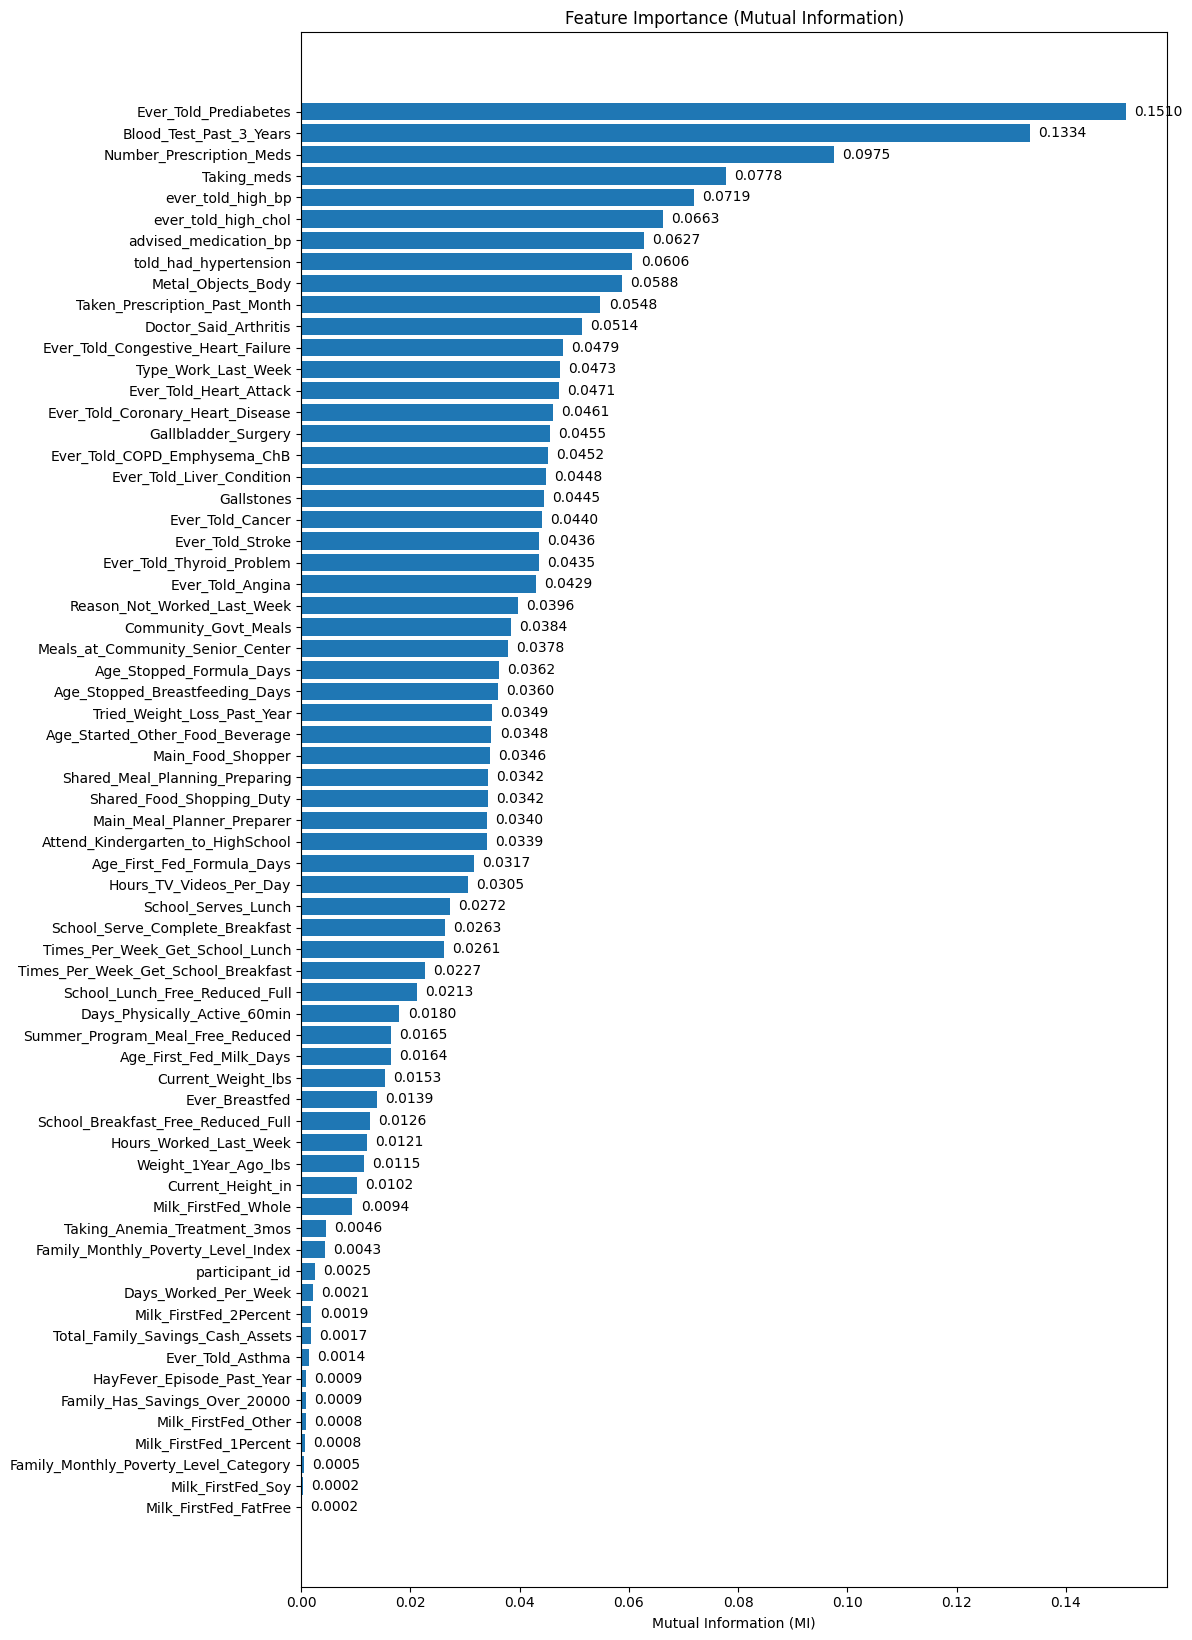

In [33]:
import matplotlib.pyplot as plt

# Sort MI values ascending for horizontal bar plot
mi_df_sorted = mi_df_imputed.sort_values("MI", ascending=True)

plt.figure(figsize=(12, max(6, len(mi_df_sorted)*0.25)))
plt.barh(mi_df_sorted["Feature"], mi_df_sorted["MI"])
plt.xlabel("Mutual Information (MI)")
plt.title("Feature Importance (Mutual Information)")

# Add value labels at the end of bars
for i, (val, feat) in enumerate(zip(mi_df_sorted["MI"], mi_df_sorted["Feature"])):
    plt.text(val + (mi_df_sorted["MI"].max()*0.01), i, f"{val:.4f}", va='center')

plt.tight_layout()
plt.show()


This step selects features whose Mutual Information (MI) with the target falls within a specific range, keeping only the most informative variables for modeling.

In [34]:
selected_features = mi_df_imputed[
    (mi_df_imputed["MI"] >= 0.0213) &
    (mi_df_imputed["MI"] <= 0.0479)
].sort_values(by="MI", ascending=False)

selected_features


,Feature,MI
18,Ever_Told_Congestive_Heart_Failure,0.047897
32,Type_Work_Last_Week,0.047347
21,Ever_Told_Heart_Attack,0.047128
19,Ever_Told_Coronary_Heart_Disease,0.046132
27,Gallbladder_Surgery,0.045539
24,Ever_Told_COPD_Emphysema_ChB,0.045224
25,Ever_Told_Liver_Condition,0.044753
26,Gallstones,0.044464
28,Ever_Told_Cancer,0.043992
22,Ever_Told_Stroke,0.043579


In [35]:
selected_feature_names = selected_features["Feature"].tolist()
selected_feature_names


['Ever_Told_Congestive_Heart_Failure',
 'Type_Work_Last_Week',
 'Ever_Told_Heart_Attack',
 'Ever_Told_Coronary_Heart_Disease',
 'Gallbladder_Surgery',
 'Ever_Told_COPD_Emphysema_ChB',
 'Ever_Told_Liver_Condition',
 'Gallstones',
 'Ever_Told_Cancer',
 'Ever_Told_Stroke',
 'Ever_Told_Thyroid_Problem',
 'Ever_Told_Angina',
 'Reason_Not_Worked_Last_Week',
 'Community_Govt_Meals',
 'Meals_at_Community_Senior_Center',
 'Age_Stopped_Formula_Days',
 'Age_Stopped_Breastfeeding_Days',
 'Tried_Weight_Loss_Past_Year',
 'Age_Started_Other_Food_Beverage',
 'Main_Food_Shopper',
 'Shared_Meal_Planning_Preparing',
 'Shared_Food_Shopping_Duty',
 'Main_Meal_Planner_Preparer',
 'Attend_Kindergarten_to_HighSchool',
 'Age_First_Fed_Formula_Days',
 'Hours_TV_Videos_Per_Day',
 'School_Serves_Lunch',
 'School_Serve_Complete_Breakfast',
 'Times_Per_Week_Get_School_Lunch',
 'Times_Per_Week_Get_School_Breakfast']

In [36]:
# Create dataframe with only selected features + target
df_selected = imputed_dataset[selected_feature_names + ["Doctor_Told_Diabetes"]].copy()

print("Selected dataset shape:", df_selected.shape)


Selected dataset shape: (11736, 31)


This step encodes categorical features: binary columns are label-encoded, while low-cardinality multi-category columns are converted to one-hot (dummy) variables, producing a fully numeric dataset ready for modeling.

In [37]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

df_model_selected = df_selected.copy()

# 1) Identify categorical columns correctly (low cardinality)
cat_cols = [
    col for col in df_selected.columns
    if df_selected[col].nunique() <= 15 and col != "Doctor_Told_Diabetes"
]

# 2) Binary columns (label encode)
binary_cols = ['Ever_Told_Prediabetes', 'Blood_Test_Past_3_Years', 'Tried_Weight_Loss_Past_Year']

for col in binary_cols:
    if col in df_model_selected.columns:
        df_model_selected[col] = LabelEncoder().fit_transform(df_model_selected[col].astype(str))

# 3) Multi-category columns (only low cardinality)
multi_cat_cols = [col for col in cat_cols if col not in binary_cols]

df_model_selected = pd.get_dummies(df_model_selected, columns=multi_cat_cols, drop_first=True)

print("After encoding, dataset shape:", df_model_selected.shape)
df_model = df_model_selected.copy()
print(df_model.shape)




After encoding, dataset shape: (11736, 76)
(11736, 76)


Target Cleaning: Doctor_Told_Diabetes

NHANES codes mapped to binary (1 = Yes, 0 = No), missing → NaN.

Dropped rows with missing target and converted to integer.

Checked final class distribution.

In [ ]:
import numpy as np

# 1. Make a safe copy
df_target_clean = df_model.copy()

# 2️. Show original unique values
print("Original unique values (including NaN):")
print(df_target_clean['Doctor_Told_Diabetes'].unique())

# 3️. Correct NHANES mapping:
# 1 = Yes
# 2 = No
# 3 = Borderline (treat as No to avoid rare class problems)
# 7/9 = Missing/Refused → NaN
mapping = {
    1: 1,
    2: 0,
    3: 0,
    7: np.nan,
    9: np.nan
}

df_target_clean['Doctor_Told_Diabetes'] = df_target_clean['Doctor_Told_Diabetes'].replace(mapping)

# 4️. Drop rows where target is still missing (7/9 were converted to NaN)
df_target_clean = df_target_clean.dropna(subset=['Doctor_Told_Diabetes'])

# 5️. Convert target to integer
df_target_clean['Doctor_Told_Diabetes'] = df_target_clean['Doctor_Told_Diabetes'].astype(int)

# 6️. Final class distribution
print("\nCleaned target value counts:")
print(df_target_clean['Doctor_Told_Diabetes'].value_counts())


Original unique values (including NaN):
[2. 1. 3.]

Cleaned target value counts:
Doctor_Told_Diabetes
0    10655
1     1081
Name: count, dtype: int64


In [39]:
print(df_target_clean.columns.shape)

(76,)


In [40]:
df_target_clean['Doctor_Told_Diabetes'].isna().sum()  # Should be 0


np.int64(0)

In [41]:
print(df_model['Doctor_Told_Diabetes'].value_counts(dropna=False))
print("Unique:", df_model['Doctor_Told_Diabetes'].unique())


Doctor_Told_Diabetes
2.0    10371
1.0     1081
3.0      284
Name: count, dtype: int64
Unique: [2. 1. 3.]


In [42]:
import numpy as np

# Correct NHANES mapping
mapping = {
    1.0: 1,   # Yes
    2.0: 0,   # No
    3.0: 0    # Borderline → No
}

df_model['Doctor_Told_Diabetes'] = df_model['Doctor_Told_Diabetes'].replace(mapping)

# Ensure no unexpected values remain
print("Unique after mapping:", df_model['Doctor_Told_Diabetes'].unique())

# Convert to integer type
df_model['Doctor_Told_Diabetes'] = df_model['Doctor_Told_Diabetes'].astype(int)


Unique after mapping: [0. 1.]


In [44]:
print(df_model.columns.shape)

(76,)


In [ ]:
# Modeling Pipeline 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    RocCurveDisplay
)

from imblearn.over_sampling import SMOTE

# Create output folder
output_dir = "outputs"
model_dir = os.path.join(output_dir, "model_1")
os.makedirs(model_dir, exist_ok=True)

# Data prep
df_model_clean = df_model.dropna(subset=['Doctor_Told_Diabetes']).copy()

X = df_model_clean.drop(columns=['Doctor_Told_Diabetes'])
y = df_model_clean['Doctor_Told_Diabetes']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

# Threshold
threshold = 0.3

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        eval_metric="logloss",
        random_state=42,
        scale_pos_weight=len(y_train_sm[y_train_sm == 0]) / len(y_train_sm[y_train_sm == 1])
    ),
    "KNN": KNeighborsClassifier(n_neighbors=15, weights="distance"),
    "SVM": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, class_weight="balanced", random_state=42)
}

# Containers
results = {}
conf_matrices = {}
roc_data = {}

# Train & Evaluate
for name, model in models.items():
    # Fit
    if name in ["Logistic Regression", "KNN", "SVM"]:
        model.fit(X_train_scaled, y_train_sm)
        y_proba = model.predict_proba(X_test_scaled)[:,1]
    else:
        model.fit(X_train_sm, y_train_sm)
        y_proba = model.predict_proba(X_test)[:,1]

    # Threshold
    y_pred = (y_proba >= threshold).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    results[name] = {"Accuracy": acc, "ROC-AUC": roc, "Balanced Accuracy": bal_acc}
    conf_matrices[name] = confusion_matrix(y_test, y_pred)
    roc_data[name] = (y_test, y_proba)

    print(f"\n{name} Classification Report (Threshold = {threshold}):\n")
    print(classification_report(y_test, y_pred))

# ROC Curve (Single Figure)
plt.figure(figsize=(8,6))
for name, (y_true, y_score) in roc_data.items():
    RocCurveDisplay.from_predictions(y_true, y_score, name=name, ax=plt.gca())

plt.plot([0,1],[0,1],"k--", label="Chance")
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(model_dir, "roc_curves_all_models.jpg"))
plt.close()
print(" ROC curves saved.")

# Confusion Matrices (Single Figure)
n_models = len(conf_matrices)
cols = 3
rows = int(np.ceil(n_models / cols))
fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
axes = axes.flatten()

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Remove empty subplots
for i in range(len(conf_matrices), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig(os.path.join(model_dir, "confusion_matrices_all_models.jpg"))
plt.close()
print(" Confusion matrices saved.")

# Model Comparison
results_df = pd.DataFrame(results).T.sort_values(by="Balanced Accuracy", ascending=False)
print("\nFinal Model Comparison:\n")
print(results_df)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:


Logistic Regression Classification Report (Threshold = 0.3):

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2132
           1       0.36      0.34      0.35       216

    accuracy                           0.88      2348
   macro avg       0.65      0.64      0.64      2348
weighted avg       0.88      0.88      0.88      2348



,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric


Random Forest Classification Report (Threshold = 0.3):

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      2132
           1       0.28      0.47      0.35       216

    accuracy                           0.84      2348
   macro avg       0.61      0.67      0.63      2348
weighted avg       0.88      0.84      0.86      2348



,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 


XGBoost Classification Report (Threshold = 0.3):

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2132
           1       0.26      0.22      0.23       216

    accuracy                           0.87      2348
   macro avg       0.59      0.58      0.58      2348
weighted avg       0.86      0.87      0.86      2348



,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",15
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'distance'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None



KNN Classification Report (Threshold = 0.3):

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2132
           1       0.28      0.39      0.33       216

    accuracy                           0.85      2348
   macro avg       0.61      0.64      0.62      2348
weighted avg       0.88      0.85      0.86      2348



,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False



SVM Classification Report (Threshold = 0.3):

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2132
           1       0.37      0.11      0.17       216

    accuracy                           0.90      2348
   macro avg       0.64      0.54      0.56      2348
weighted avg       0.87      0.90      0.88      2348



,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",6
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no


Decision Tree Classification Report (Threshold = 0.3):

              precision    recall  f1-score   support

           0       0.96      0.74      0.84      2132
           1       0.21      0.69      0.33       216

    accuracy                           0.74      2348
   macro avg       0.59      0.72      0.58      2348
weighted avg       0.89      0.74      0.79      2348



<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'ROC Curves for All Models')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

✅ ROC curves saved.


<Axes: >

Text(0.5, 1.0, 'Logistic Regression')

Text(0.5, 394.72222222222223, 'Predicted')

Text(158.22222222222223, 0.5, 'Actual')

<Axes: >

Text(0.5, 1.0, 'Random Forest')

Text(0.5, 394.72222222222223, 'Predicted')

Text(568.5163398692812, 0.5, 'Actual')

<Axes: >

Text(0.5, 1.0, 'XGBoost')

Text(0.5, 394.72222222222223, 'Predicted')

Text(978.81045751634, 0.5, 'Actual')

<Axes: >

Text(0.5, 1.0, 'KNN')

Text(0.5, 58.7222222222222, 'Predicted')

Text(158.22222222222223, 0.5, 'Actual')

<Axes: >

Text(0.5, 1.0, 'SVM')

Text(0.5, 58.7222222222222, 'Predicted')

Text(568.5163398692812, 0.5, 'Actual')

<Axes: >

Text(0.5, 1.0, 'Decision Tree')

Text(0.5, 58.7222222222222, 'Predicted')

Text(978.81045751634, 0.5, 'Actual')

✅ Confusion matrices saved.

Final Model Comparison:

                     Accuracy   ROC-AUC  Balanced Accuracy
Decision Tree        0.736371  0.780957           0.717532
Random Forest        0.841993  0.823443           0.673759
KNN                  0.853918  0.795010           0.644960
Logistic Regression  0.884583  0.844697           0.641043
XGBoost              0.869676  0.788837           0.576667
SVM                  0.901193  0.705239           0.544094


In [47]:
from sklearn.metrics import precision_recall_curve

y_scores = model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Example: pick threshold where recall ≥ 0.7
for p, r, t in zip(precision, recall, thresholds):
    if r >= 0.7:
        print("Threshold:", t, "Precision:", p, "Recall:", r)
        break


Threshold: 0.0 Precision: 0.0919931856899489 Recall: 1.0


(array([777.,   0.,   0.,   0., 117., 470.,   0.,   0.,   0.,   0.,   0.,
          0.,  73.,   0., 142.,   0.,   7., 182.,  22.,  11.,   0.,   1.,
          0.,  10.,   0.,  71.,   0.,  26.,   0.,   0.,   0.,  20.,   0.,
         62.,   3.,   0.,  16.,  82.,   0.,  13.,   1.,   2.,   0.,   0.,
          3.,   4.,   0.,  11.,   0.,   6.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

(array([ 5.,  0.,  0.,  0., 14., 16.,  0.,  0.,  0.,  0.,  0.,  0., 14.,
         0., 17.,  0.,  5., 20.,  9.,  8.,  0.,  0.,  0.,  2.,  0., 27.,
         0.,  3.,  0.,  0.,  0., 17.,  0., 20.,  0.,  0.,  4., 25.,  0.,
         2.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  4.,  0.,  1.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

Text(0.5, 1.0, 'Predicted probability distribution')

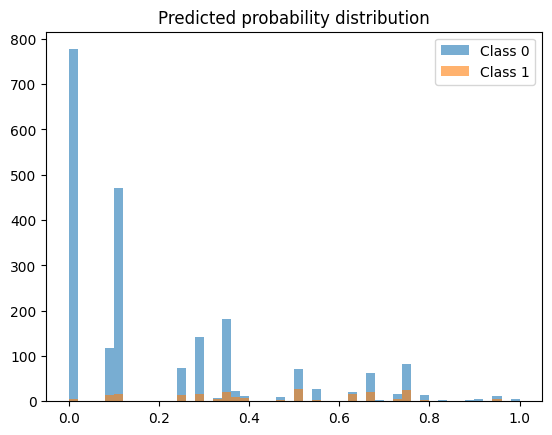

In [48]:
import matplotlib.pyplot as plt

plt.hist(y_scores[y_test == 0], bins=50, alpha=0.6, label='Class 0')
plt.hist(y_scores[y_test == 1], bins=50, alpha=0.6, label='Class 1')
plt.legend()
plt.title("Predicted probability distribution")
plt.show()


In [ ]:
#  Recall-Focused & Imbalance-Aware Modeling
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    RocCurveDisplay
)

from imblearn.over_sampling import SMOTE

# Output Folder
output_dir = "outputs"
model_dir = os.path.join(output_dir, "model_2")
os.makedirs(model_dir, exist_ok=True)

# Data Preparation
df_model_clean = df_model.dropna(subset=['Doctor_Told_Diabetes']).copy()

X = df_model_clean.drop(columns=['Doctor_Told_Diabetes'])
y = df_model_clean['Doctor_Told_Diabetes']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Class Imbalance Ratio
neg_pos_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# SMOTE (Train Only)
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

# Threshold
threshold = 0.3

# Models
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, class_weight={0:1, 1:5}, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=300, class_weight={0:1,1:5}, random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        eval_metric="logloss",
        scale_pos_weight=neg_pos_ratio,
        random_state=42
    ),
    "KNN": KNeighborsClassifier(n_neighbors=15, weights="distance"),
    "SVM": SVC(kernel="rbf", probability=True, class_weight={0:1,1:5}, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, class_weight={0:1,1:5}, random_state=42)
}

# Containers
results = {}
conf_matrices = {}
roc_data = {}

# Train, Predict & Store
for name, model in models.items():

    # Fit model
    if name in ["Logistic Regression", "KNN", "SVM"]:
        model.fit(X_train_scaled, y_train_sm)
        y_proba = model.predict_proba(X_test_scaled)[:,1]
    else:
        model.fit(X_train_sm, y_train_sm)
        y_proba = model.predict_proba(X_test)[:,1]

    # Threshold prediction
    y_pred = (y_proba >= threshold).astype(int)

    # Metrics
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred)
    }

    conf_matrices[name] = confusion_matrix(y_test, y_pred)
    roc_data[name] = (y_test, y_proba)

    print(f"\n{name} Classification Report (Threshold={threshold}):\n")
    print(classification_report(y_test, y_pred))

# ROC Curves (Single Figure)
plt.figure(figsize=(8,6))
for name, (y_true, y_score) in roc_data.items():
    RocCurveDisplay.from_predictions(y_true, y_score, name=name, ax=plt.gca())

plt.plot([0,1],[0,1],"k--", label="Chance")
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(model_dir, "roc_curves_all_models.jpg"))
plt.close()
print(" ROC curves saved in 'outputs/model_2'")

# Confusion Matrices (Single Figure)
cols = 3
rows = int(np.ceil(len(conf_matrices)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
axes = axes.flatten()

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Remove unused axes
for i in range(len(conf_matrices), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig(os.path.join(model_dir, "confusion_matrices_all_models.jpg"))
plt.close()
print(" Confusion matrices saved in 'outputs/model_2'")

# Model Comparison
results_df = pd.DataFrame(results).T.sort_values(by="Balanced Accuracy", ascending=False)
print("\nFinal Model Comparison:\n")
print(results_df)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*","{0: 1, 1: 5}"
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :t


Logistic Regression Classification Report (Threshold=0.3):

              precision    recall  f1-score   support

           0       0.99      0.60      0.75      2132
           1       0.19      0.93      0.32       216

    accuracy                           0.63      2348
   macro avg       0.59      0.77      0.53      2348
weighted avg       0.91      0.63      0.71      2348



,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric


Random Forest Classification Report (Threshold=0.3):

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      2132
           1       0.27      0.43      0.33       216

    accuracy                           0.84      2348
   macro avg       0.60      0.65      0.62      2348
weighted avg       0.88      0.84      0.85      2348



,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 


XGBoost Classification Report (Threshold=0.3):

              precision    recall  f1-score   support

           0       0.94      0.86      0.89      2132
           1       0.23      0.42      0.29       216

    accuracy                           0.82      2348
   macro avg       0.58      0.64      0.59      2348
weighted avg       0.87      0.82      0.84      2348



,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",15
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'distance'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None



KNN Classification Report (Threshold=0.3):

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2132
           1       0.28      0.39      0.33       216

    accuracy                           0.85      2348
   macro avg       0.61      0.64      0.62      2348
weighted avg       0.88      0.85      0.86      2348



,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.","{0: 1, 1: 5}"
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False



SVM Classification Report (Threshold=0.3):

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      2132
           1       0.30      0.52      0.38       216

    accuracy                           0.84      2348
   macro avg       0.62      0.70      0.64      2348
weighted avg       0.89      0.84      0.86      2348



,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",6
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no


Decision Tree Classification Report (Threshold=0.3):

              precision    recall  f1-score   support

           0       0.99      0.53      0.69      2132
           1       0.17      0.94      0.29       216

    accuracy                           0.57      2348
   macro avg       0.58      0.74      0.49      2348
weighted avg       0.91      0.57      0.66      2348



<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'ROC Curves for All Models')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

✅ ROC curves saved in 'outputs/model_2'


<Axes: >

Text(0.5, 1.0, 'Logistic Regression')

Text(0.5, 394.72222222222223, 'Predicted')

Text(158.22222222222223, 0.5, 'Actual')

<Axes: >

Text(0.5, 1.0, 'Random Forest')

Text(0.5, 394.72222222222223, 'Predicted')

Text(568.5163398692812, 0.5, 'Actual')

<Axes: >

Text(0.5, 1.0, 'XGBoost')

Text(0.5, 394.72222222222223, 'Predicted')

Text(978.81045751634, 0.5, 'Actual')

<Axes: >

Text(0.5, 1.0, 'KNN')

Text(0.5, 58.7222222222222, 'Predicted')

Text(158.22222222222223, 0.5, 'Actual')

<Axes: >

Text(0.5, 1.0, 'SVM')

Text(0.5, 58.7222222222222, 'Predicted')

Text(568.5163398692812, 0.5, 'Actual')

<Axes: >

Text(0.5, 1.0, 'Decision Tree')

Text(0.5, 58.7222222222222, 'Predicted')

Text(978.81045751634, 0.5, 'Actual')

✅ Confusion matrices saved in 'outputs/model_2'

Final Model Comparison:

                     Accuracy   ROC-AUC  Balanced Accuracy
Logistic Regression  0.634157  0.847696           0.765261
Decision Tree        0.570273  0.788492           0.736324
SVM                  0.843271  0.820691           0.697346
Random Forest        0.838586  0.818864           0.653160
KNN                  0.853918  0.795010           0.644960
XGBoost              0.815588  0.783020           0.636335



--- STEP 9: Model Interpretability (SHAP + LIME) ---

Best model selected for interpretability: Logistic Regression

Running SHAP...


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'SHAP Feature Importance (Logistic Regression)')

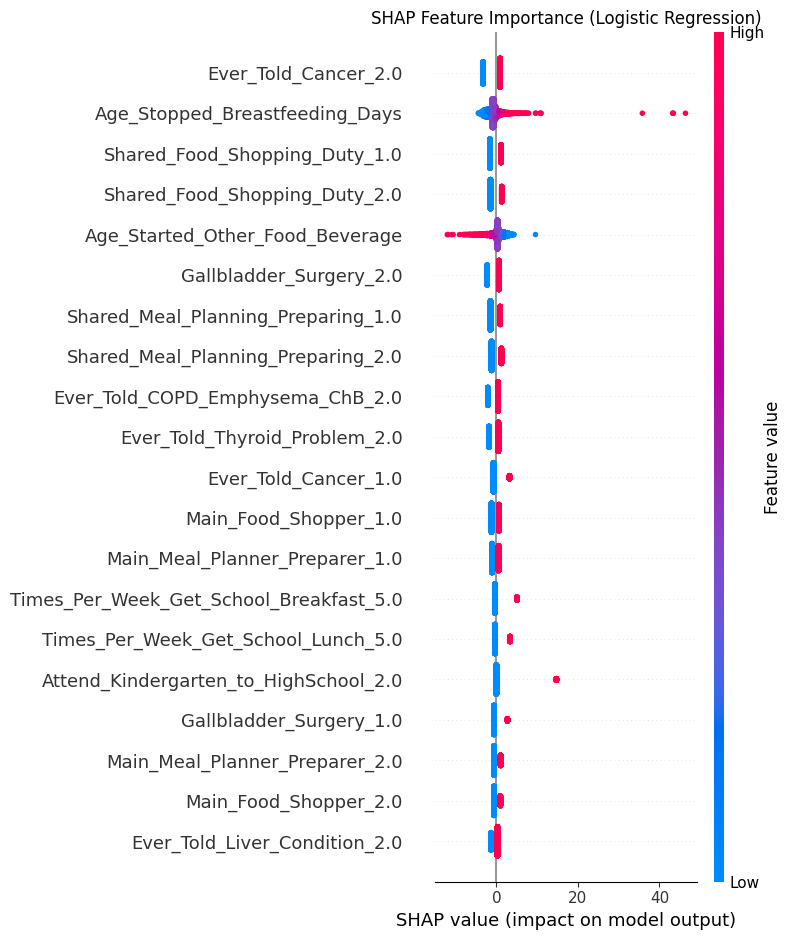


Running LIME...


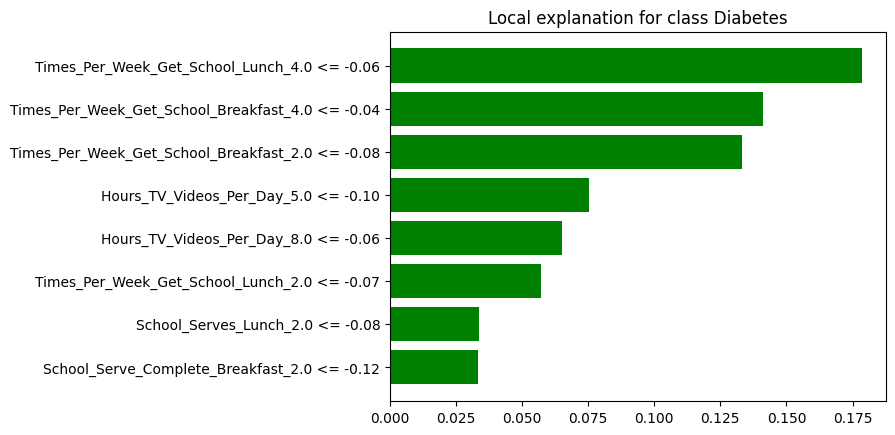

Text(0.5, 1.0, 'LIME Explanation (Logistic Regression)')

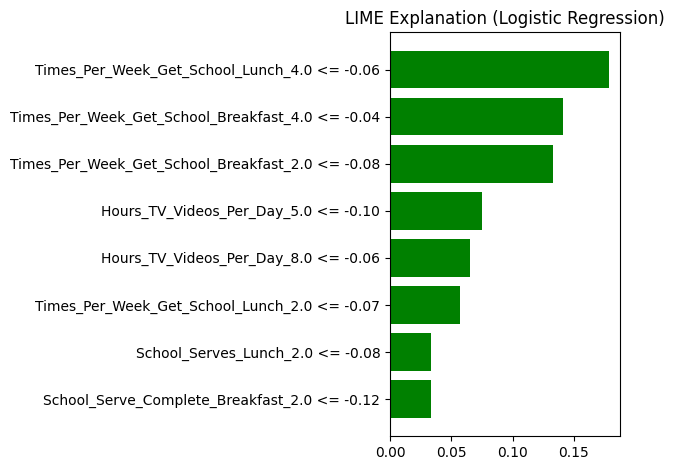

In [ ]:
#  SHAP & LIME INTERPRETABILITY

import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np

print("\n--- STEP 9: Model Interpretability (SHAP + LIME) ---")

# Select Best Model
best_model_name = results_df.index[0]
best_model = models[best_model_name]

print(f"\nBest model selected for interpretability: {best_model_name}")

# Determine correct data representation
if best_model_name in ["Logistic Regression", "KNN", "SVM"]:
    X_train_used = X_train_scaled
    X_test_used = X_test_scaled
else:
    X_train_used = X_train_sm
    X_test_used = X_test

feature_names = X.columns.tolist()

# SHAP Global Explanation
print("\nRunning SHAP...")

try:
    # Tree models
    if best_model_name in ["Random Forest", "Decision Tree", "XGBoost"]:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test_used)

        if isinstance(shap_values, list):
            shap_vals = shap_values[1]
        elif len(np.array(shap_values).shape) == 3:
            shap_vals = shap_values[:, :, 1]
        else:
            shap_vals = shap_values

    # Linear models
    elif best_model_name == "Logistic Regression":
        explainer = shap.LinearExplainer(best_model, X_train_used)
        shap_vals = explainer.shap_values(X_test_used)

    # Kernel fallback (for KNN, SVM, etc.)
    else:
        explainer = shap.KernelExplainer(
            best_model.predict_proba,
            shap.sample(X_train_used, 100)
        )
        shap_vals = explainer.shap_values(X_test_used[:100])[1]

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_vals,
        X_test_used,
        feature_names=feature_names,
        show=False
    )
    plt.title(f"SHAP Feature Importance ({best_model_name})")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("SHAP failed:", e)

# LIME Local Explanation
print("\nRunning LIME...")

try:
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train_used,
        feature_names=feature_names,
        class_names=['Healthy', 'Diabetes'],
        mode='classification'
    )

    exp = lime_explainer.explain_instance(
        X_test_used[0],
        best_model.predict_proba,
        num_features=8
    )

    exp.as_pyplot_figure()
    plt.title(f"LIME Explanation ({best_model_name})")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("LIME failed:", e)


In [ ]:
from sklearn.metrics import recall_score

print("\nRecall for Positive Class (Diabetes = 1):\n")

recall_results = {}

for name, cm in conf_matrices.items():
    # cm format: [[TN, FP],
    #             [FN, TP]]
    tn, fp, fn, tp = cm.ravel()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    recall_results[name] = recall
    print(f"{name:<20} : {recall:.3f}")


recall_df = pd.DataFrame.from_dict(
    recall_results, orient="index", columns=["Recall (Class 1)"]
).sort_values(by="Recall (Class 1)", ascending=False)

print("\nRecall Comparison Table:\n")
print(recall_df)



Recall for Positive Class (Diabetes = 1):

Logistic Regression  : 0.926
Random Forest        : 0.426
XGBoost              : 0.417
KNN                  : 0.389
SVM                  : 0.519
Decision Tree        : 0.940

Recall Comparison Table:

                     Recall (Class 1)
Decision Tree                0.939815
Logistic Regression          0.925926
SVM                          0.518519
Random Forest                0.425926
XGBoost                      0.416667
KNN                          0.388889


In [ ]:
# Ensemble Models (Save Plots in outputs/ensemble)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import (
    VotingClassifier,
    StackingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    RocCurveDisplay
)

# Create Output Folder
output_dir = "outputs"
ensemble_dir = os.path.join(output_dir, "ensemble")
os.makedirs(ensemble_dir, exist_ok=True)

# Base Models
lr = LogisticRegression(max_iter=1000, class_weight={0:1,1:5}, random_state=42)
rf = RandomForestClassifier(n_estimators=300, class_weight={0:1,1:5}, random_state=42)
svm = SVC(kernel="rbf", probability=True, class_weight={0:1,1:5}, random_state=42)

# Ensemble Models
ensemble_models = {
    "Voting (Hard)": VotingClassifier(
        estimators=[("lr", lr), ("rf", rf), ("svm", svm)],
        voting="hard"
    ),
    "Voting (Soft)": VotingClassifier(
        estimators=[("lr", lr), ("rf", rf), ("svm", svm)],
        voting="soft"
    ),
    "Stacking": StackingClassifier(
        estimators=[("lr", lr), ("rf", rf), ("svm", svm)],
        final_estimator=LogisticRegression(max_iter=1000),
        passthrough=False
    ),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42)
}

# Containers
ensemble_results = {}
ensemble_conf_matrices = {}
roc_data = {}

# Training, Evaluation & Store
for name, model in ensemble_models.items():

    # Scale input if needed
    if name in ["Voting (Hard)", "Voting (Soft)", "Stacking"]:
        model.fit(X_train_scaled, y_train_sm)

        # Voting Hard has no probabilities
        if name == "Voting (Hard)":
            y_pred = model.predict(X_test_scaled)
            y_proba = y_pred  # dummy
        else:
            y_proba = model.predict_proba(X_test_scaled)[:,1]
            y_pred = (y_proba >= threshold).astype(int)
            roc_data[name] = (y_test, y_proba)
    else:
        model.fit(X_train_sm, y_train_sm)
        y_proba = model.predict_proba(X_test)[:,1]
        y_pred = (y_proba >= threshold).astype(int)
        roc_data[name] = (y_test, y_proba)

    # Metrics
    ensemble_results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred)
    }
    # ROC-AUC if probabilities exist
    if name != "Voting (Hard)":
        ensemble_results[name]["ROC-AUC"] = roc_auc_score(y_test, y_proba)
    else:
        ensemble_results[name]["ROC-AUC"] = np.nan

    ensemble_conf_matrices[name] = confusion_matrix(y_test, y_pred)

    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

# ROC Curves (Single Figure)
plt.figure(figsize=(8,6))
for name, (y_true, y_score) in roc_data.items():
    RocCurveDisplay.from_predictions(y_true, y_score, name=name, ax=plt.gca())

plt.plot([0,1],[0,1],"k--", label="Chance")
plt.title("ROC Curves for Ensemble Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(ensemble_dir, "roc_curves_ensemble.jpg"))
plt.close()
print(" ROC curves saved in 'outputs/ensemble/'")

# Confusion Matrices (Single Figure)
cols = 2
rows = int(np.ceil(len(ensemble_conf_matrices)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.flatten()

for ax, (name, cm) in zip(axes, ensemble_conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Remove unused axes
for i in range(len(ensemble_conf_matrices), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig(os.path.join(ensemble_dir, "confusion_matrices_ensemble.jpg"))
plt.close()
print(" Confusion matrices saved in 'outputs/ensemble/'")

# Ensemble Comparison
ensemble_results_df = pd.DataFrame(ensemble_results).T.sort_values(by="Balanced Accuracy", ascending=False)
print("\nEnsemble Model Comparison:\n")
print(ensemble_results_df)


,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('lr', ...), ('rf', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'hard'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001



Voting (Hard) Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.86      0.91      2132
           1       0.30      0.58      0.40       216

    accuracy                           0.84      2348
   macro avg       0.63      0.72      0.65      2348
weighted avg       0.89      0.84      0.86      2348



,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('lr', ...), ('rf', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'soft'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001



Voting (Soft) Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.82      0.88      2132
           1       0.27      0.66      0.38       216

    accuracy                           0.80      2348
   macro avg       0.61      0.74      0.63      2348
weighted avg       0.90      0.80      0.84      2348



,"estimators estimators: list of (str, estimator)Base estimators which will be stacked together. Each element of thelist is defined as a tuple of string (i.e. name) and an estimatorinstance. An estimator can be set to 'drop' using `set_params`.The type of estimator is generally expected to be a classifier.However, one can pass a regressor for some use case (e.g. ordinalregression).","[('lr', ...), ('rf', ...), ...]"
,"final_estimator final_estimator: estimator, default=NoneA classifier which will be used to combine the base estimators.The default classifier is a:class:`~sklearn.linear_model.LogisticRegression`.",LogisticRegre...max_iter=1000)
,"cv cv: int, cross-validation generator, iterable, or ""prefit"", default=NoneDetermines the cross-validation splitting strategy used in`cross_val_predict` to train `final_estimator`. Possible inputs forcv are:* None, to use the default 5-fold cross validation,* integer, to specify the number of folds in a (Stratified) KFold,* An object to be used as a cross-validation generator,* An iterable yielding train, test splits,* `""prefit""`, to assume the `estimators` are prefit. In this case, the estimators will not be refitted.For integer/None inputs, if the estimator is a classifier and y iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used.In all other cases, :class:`~sklearn.model_selection.KFold` is used.These splitters are instantiated with `shuffle=False` so the splitswill be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.If ""prefit"" is passed, it is assumed that all `estimators` havebeen fitted already. The `final_estimator_` is trained on the `estimators`predictions on the full training set and are **not** cross validatedpredictions. Please note that if the models have been trained on the samedata to train the stacking model, there is a very high risk of overfitting... versionadded:: 1.1 The 'prefit' option was added in 1.1.. note:: A larger number of split will provide no benefits if the number of training samples is large enough. Indeed, the training time will increase. ``cv`` is not used for model evaluation but for prediction.",None
,"stack_method stack_method: {'auto', 'predict_proba', 'decision_function', 'predict'}, default='auto'Methods called for each base estimator. It can be:* if 'auto', it will try to invoke, for each estimator, `'predict_proba'`, `'decision_function'` or `'predict'` in that order.* otherwise, one of `'predict_proba'`, `'decision_function'` or `'predict'`. If the method is not implemented by the estimator, it will raise an error.",'auto'
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for `fit` of all `estimators`.`None` means 1 unless in a `joblib.parallel_backend` context. -1 meansusing all processors. See :term:`Glossary ` for more details.",None
,"passthrough passthrough: bool, default=FalseWhen False, only the predictions of estimators will be used astraining data for `final_estimator`. When True, the`final_estimator` is trained on the predictions as well as theoriginal training data.",False
,"verbose verbose: int, default=0Verbosity level.",0
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default


Stacking Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.96      0.93      2132
           1       0.22      0.12      0.16       216

    accuracy                           0.88      2348
   macro avg       0.57      0.54      0.55      2348
weighted avg       0.85      0.88      0.86      2348



,"estimator estimator: object, default=NoneThe base estimator from which the boosted ensemble is built.Support for sample weighting is required, as well as proper``classes_`` and ``n_classes_`` attributes. If ``None``, thenthe base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`initialized with `max_depth=1`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",None
,"n_estimators n_estimators: int, default=50The maximum number of estimators at which boosting is terminated.In case of perfect fit, the learning procedure is stopped early.Values must be in the range `[1, inf)`.",200
,"learning_rate learning_rate: float, default=1.0Weight applied to each classifier at each boosting iteration. A higherlearning rate increases the contribution of each classifier. There isa trade-off between the `learning_rate` and `n_estimators` parameters.Values must be in the range `(0.0, inf)`.",1.0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random seed given at each `estimator` at eachboosting iteration.Thus, it is only used when `estimator` exposes a `random_state`.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42



AdaBoost Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2132
           1       0.09      1.00      0.17       216

    accuracy                           0.09      2348
   macro avg       0.05      0.50      0.08      2348
weighted avg       0.01      0.09      0.02      2348



,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",200
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, 


Gradient Boosting Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2132
           1       0.33      0.41      0.36       216

    accuracy                           0.87      2348
   macro avg       0.63      0.66      0.65      2348
weighted avg       0.88      0.87      0.88      2348



<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'ROC Curves for Ensemble Models')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

✅ ROC curves saved in 'outputs/ensemble/'


<Axes: >

Text(0.5, 1.0, 'Voting (Hard)')

Text(0.5, 754.9575163398694, 'Predicted')

Text(120.72222222222221, 0.5, 'Actual')

<Axes: >

Text(0.5, 1.0, 'Voting (Soft)')

Text(0.5, 754.9575163398694, 'Predicted')

Text(627.9949494949494, 0.5, 'Actual')

<Axes: >

Text(0.5, 1.0, 'Stacking')

Text(0.5, 428.8398692810457, 'Predicted')

Text(120.72222222222221, 0.5, 'Actual')

<Axes: >

Text(0.5, 1.0, 'AdaBoost')

Text(0.5, 428.8398692810457, 'Predicted')

Text(627.9949494949494, 0.5, 'Actual')

<Axes: >

Text(0.5, 1.0, 'Gradient Boosting')

Text(0.5, 102.72222222222219, 'Predicted')

Text(120.72222222222221, 0.5, 'Actual')

✅ Confusion matrices saved in 'outputs/ensemble/'

Ensemble Model Comparison:

                   Accuracy  Balanced Accuracy   ROC-AUC
Voting (Soft)      0.802811           0.739555  0.846278
Voting (Hard)      0.838586           0.721810       NaN
Gradient Boosting  0.868825           0.661490  0.836107
Stacking           0.879046           0.540220  0.524853
AdaBoost           0.091993           0.500000  0.841693


end of doc here

Dropped columns: ['Doctor_Told_Diabetes']
Final feature shape: (11736, 75)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi


Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2132
           1       0.51      0.08      0.14       216

    accuracy                           0.91      2348
   macro avg       0.71      0.54      0.55      2348
weighted avg       0.88      0.91      0.88      2348



<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

Text(0.5, 14.722222222222216, 'Predicted')

Text(33.22222222222222, 0.5, 'Actual')

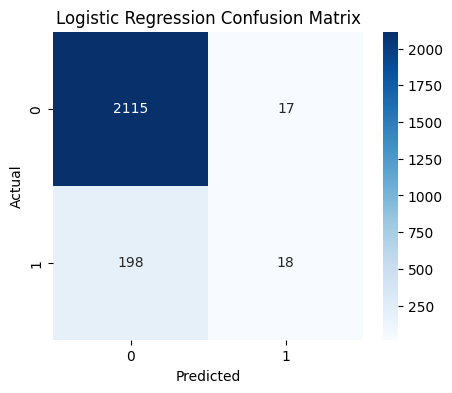

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2132
           1       0.30      0.06      0.09       216

    accuracy                           0.90      2348
   macro avg       0.61      0.52      0.52      2348
weighted avg       0.86      0.90      0.87      2348



<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Random Forest Confusion Matrix')

Text(0.5, 14.722222222222216, 'Predicted')

Text(33.22222222222222, 0.5, 'Actual')

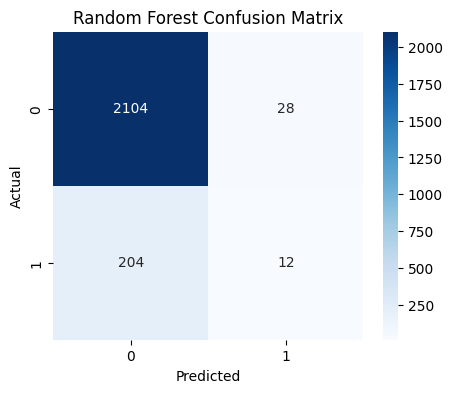

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 


XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      2132
           1       0.39      0.17      0.24       216

    accuracy                           0.90      2348
   macro avg       0.65      0.57      0.59      2348
weighted avg       0.87      0.90      0.88      2348



<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'XGBoost Confusion Matrix')

Text(0.5, 14.722222222222216, 'Predicted')

Text(33.22222222222222, 0.5, 'Actual')

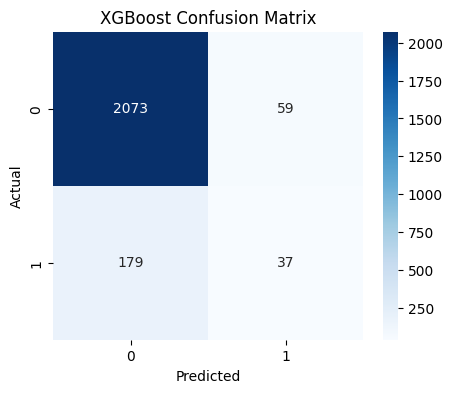


Baseline Model Comparison:

                     Accuracy   ROC-AUC
Logistic Regression  0.908433  0.855756
Random Forest        0.901193  0.827412
XGBoost              0.898637  0.798605


In [ ]:
# Baseline Modeling Pipeline (Without Leaky Columns)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Drop rows where target is missing
df_model_clean = df_model.dropna(subset=['Doctor_Told_Diabetes']).copy()

# Feature / Target Preparation
leaky_columns = ['Ever_Told_Prediabetes', 'Blood_Test_Past_3_Years']
base_drop_cols = ['Doctor_Told_Diabetes', 'participant_id']

# Drop only columns that actually exist (prevents KeyError)
cols_to_drop = [c for c in base_drop_cols + leaky_columns if c in df_model_clean.columns]

X = df_model_clean.drop(columns=cols_to_drop)
y = df_model_clean['Doctor_Told_Diabetes']

print("Dropped columns:", cols_to_drop)
print("Final feature shape:", X.shape)

# Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Scaling (Logistic Regression only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        eval_metric='logloss',
        random_state=42
    )
}

# Training & Evaluation
results = {}

for name, model in models.items():
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    results[name] = {"Accuracy": acc, "ROC-AUC": roc}

    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Model Comparison
results_df = pd.DataFrame(results).T.sort_values(by="ROC-AUC", ascending=False)
print("\nBaseline Model Comparison:\n")
print(results_df)
